In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import datetime 
from tqdm import tqdm
import pytz
from matplotlib import pyplot as plt 
import warnings
from sklearn.metrics import accuracy_score
from datetime import date
import random
from scipy.optimize import minimize

warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
tz = pytz.timezone("America/New_York")

In [25]:
tweets_df = pd.read_csv('../data/tweets.csv', on_bad_lines = 'skip')

tweets_df["timestamp"] = pd.to_datetime(tweets_df["timestamp"])
tweets_df ['date'] = tweets_df ['timestamp'].dt.date

new_rows = []
idx_del = []

for idx, row in tweets_df.iterrows():
    
    if '-' in row['symbols']:       
        symbols =  row['symbols'].split('-')
        idx_del.append(idx) 
        
        for s in symbols:
            nr = row.copy()
            nr['symbols'] = s
#             print(row)
            new_rows.append(nr)
tweets_df=tweets_df.drop(idx_del)    
tweets_df=tweets_df.append(new_rows, ignore_index = True)

tweets_df

id                                               text  \
0    1.630000e+18  Frustration with PowerPoint the iconic slide p...   
1    1.630000e+18  Tyler ‰ÛÏNinja‰Û Blevins Joins GameSquare As ...   
2    1.630000e+18  How big is the storm in cloud software? Salesf...   
3    1.630000e+18  Nokia changes iconic logo to signal strategy s...   
4    1.630000e+18  Check Point CEO Gil Shwed On ChatGPT And Cyber...   
..            ...                                                ...   
675  1.630000e+18  Amex Mastercard Visa pause work on new firearm...   
676  1.630000e+18  Oracle banks on Cerner for cloud boost after m...   
677  1.630000e+18  Oracle banks on Cerner for cloud boost after m...   
678  1.640000e+18  Though politicians' calls to ban TikTok appear...   
679  1.640000e+18  Though politicians' calls to ban TikTok appear...   

                    timestamp        source symbols      company_names  \
0   2023-02-26 09:20:08+00:00        Forbes    MSFT          Microsoft   
1   2023-02-26 11:40:07+00:00        Forbes      SQ             Square   
2   2023-02-26 13:04:11+00:00   MarketWatch     CRM         salesforce   
3   2023-02-26 13:05:08+00:00       Reuters     NOK              Nokia   
4   2023-02-26 14:50:04+00:00        Forbes    CHKP        Check Point   
..                        ...           ...     ...                ...   
675 2023-03-10 02:01:03+00:00       Reuters      MA    Visa*Mastercard   
676 2023-03-10 02:45:24+00:00       Reuters    ORCL      Oracle*Cerner   
677 2023-03-10 02:45:24+00:00       Reuters    CERN      Oracle*Cerner   
678 2023-03-13 04:34:16+00:00  YahooFinance   GOOGL  Alphabet*Alphabet   
679 2023-03-13 04:34:16+00:00  YahooFinance    GOOG  Alphabet*Alphabet   

                                                   url  verified  pred_sen  \
0    https://twitter.com/i/web/status/1629773296039...       NaN         2   
1    https://twitter.com/i/web/status/1629808523470...       NaN         2   
2                          https://trib.al/2ifGBqItrue       NaN         2   
3                           http://reut.rs/3Z13DIdtrue       NaN         2   
4                          https://trib.al/xYlgOgitrue       NaN         2   
..                                                 ...       ...       ...   
675                         http://reut.rs/3J5cjXwtrue       NaN         2   
676                         http://reut.rs/3l2Gwyqtrue       NaN         2   
677                         http://reut.rs/3l2Gwyqtrue       NaN         2   
678  https://twitter.com/i/web/status/1635137176684...       NaN         2   
679  https://twitter.com/i/web/status/1635137176684...       NaN         2   

           date  
0    2023-02-26  
1    2023-02-26  
2    2023-02-26  
3    2023-02-26  
4    2023-02-26  
..          ...  
675  2023-03-10  
676  2023-03-10  
677  2023-03-10  
678  2023-03-13  
679  2023-03-13  

[680 rows x 10 columns]

In [26]:
sa_df = pd.read_csv('../data/seeking_alpha_pred.csv')

date_new = []
for idx,row in sa_df.iterrows():
    arr = row['date'].split(" ")
    date = arr[0]
    date_new.append(date)
    
date_new_df=pd.DataFrame(date_new)
date_new_df.columns = ['date_new']
sa_df = sa_df.join(date_new_df)
sa_df['date_new'] = pd.to_datetime(sa_df['date_new'])
sa_df['date'] = sa_df['date_new'].dt.date
sa_df.pop('date_new')
sa_df

author        date  ticker  \
0    Daniel Jones  2023-03-13    ^DJI   
1    Daniel Jones  2023-03-13    ^NDX   
2    Daniel Jones  2023-03-13   ^GSPC   
3    Daniel Jones  2023-03-13    ^SPX   
4    Daniel Jones  2023-03-11     BMI   
..            ...         ...     ...   
228  Hoya Capital  2023-02-27     MMM   
229  Hoya Capital  2023-02-27     ENB   
230  Hoya Capital  2023-02-27  ENB.TO   
231  Hoya Capital  2023-02-26    QRMI   
232  Hoya Capital  2023-02-26    XRMI   

                                               summary  pred_sen  
0    Markets have been volatile, initially starting...         0  
1    Markets have been volatile, initially starting...         0  
2    Markets have been volatile, initially starting...         0  
3    Markets have been volatile, initially starting...         0  
4    Badger Meter continues to grow, and most of it...         2  
..                                                 ...       ...  
228  3M is now trading at a very low valuation and ...         2  
229  Enbridge's utilization levels remain high, wit...         2  
230  Enbridge's utilization levels remain high, wit...         2  
231  The Global X S&P 500 Risk Managed Income ETF i...         1  
232  The Global X S&P 500 Risk Managed Income ETF i...         1  

[233 rows x 5 columns]

In [27]:
print(tweets_df['source'].value_counts())
print(sa_df['author'].value_counts())
# print(tweets_df['source'].value_counts().loc[20])

Reuters           171
business          121
MarketWatch        86
YahooFinance       73
Forbes             45
GerberKawasaki     37
WSJ                35
TheStreet          33
TechCrunch         26
nytimes            16
TheStalwart         7
FT                  7
bespokeinvest       7
TheEconomist        5
StockTwits          4
jimcramer           2
SeanaNSmith         2
ianbremmer          1
MorganStanley       1
GoldmanSachs        1
Name: source, dtype: int64
Daniel Jones       45
Hoya Capital       44
Stephen Simpson    42
Trapping Value     33
Taylor Dart        30
Gen Alpha          25
Nick Ackerman      14
Name: author, dtype: int64


In [28]:
def price_moving_level (symbol,date, window,threshold_trend,threshold_price):
    
    stock = yf.Ticker(symbol)
    start_date =  date - datetime.timedelta(days=1)
    end_date = date + datetime.timedelta(days=10)
    
    start_date = start_date.strftime('%Y-%m-%d')
    end_date = end_date.strftime('%Y-%m-%d')
    df_stock = stock.history(start = start_date, end =end_date).reset_index()
    rtn_trend , rtn_price = -1, -1
    
    if df_stock.empty:
        return rtn_trend , rtn_price   
#         return False
    else:
        df_stock["Date"] = pd.to_datetime(df_stock["Date"])
        df_stock['date'] = df_stock['Date'].dt.date
        date = pd.to_datetime (date)
        p0 = df_stock[df_stock['date']==pd.Timestamp(date)]['Close'].values
#         print(p0)
        h0 = df_stock[df_stock['date']==pd.Timestamp(date)]['High'].values
        l0 = df_stock[df_stock['date']==pd.Timestamp(date)]['Low'].values
        
        if p0.size ==0:
            
            return rtn_trend , rtn_price
#             return False
        
        else:            
            next_idx = df_stock[df_stock['date']==pd.Timestamp(date)].index + window
            p1=df_stock.loc[next_idx]['Close'].values
#             print(p1)
            h1 = df_stock.loc[next_idx]['High'].values
            l1 = df_stock.loc[next_idx]['Low'].values
        
            TD_h1l0 = (h1[0]-l0[0] )/l0[0]
            TD_l1h0 = (l1[0]-h0[0] )/h0[0]
            
            if abs(TD_h1l0) > abs(TD_l1h0):
                l = TD_h1l0
            else:
                l = TD_l1h0

            p = (p1[0]-p0[0] )/p0[0]
#             print(df_stock)
#             print(symbol, date,p, TD_h1l0,TD_l1h0)
            
            
            if l >= threshold_trend:
                rtn_trend = 2
            elif l <= -threshold_trend :
                rtn_trend = 0
            else:
                rtn_trend = 1

            if p >= threshold_price:
                rtn_price= 2
            elif p <= -threshold_price :
                rtn_price = 0
            else:
                rtn_price = 1
                
            return rtn_trend, rtn_price
    
def evaluate_tweet(author,window,threshold_trend,threshold_price):
    df_all = tweets_df[tweets_df['source']==author]
    dates = df_all['date'].value_counts()
    
    sen_arr = []
    trend_arr = []
    price_arr = []
    
    print(dates)
    for date, cnt_date in tqdm(dates.iteritems()):
        df_today = df_all[df_all['date'] == date]
        symbols= df_today['symbols'].value_counts()
        
        for sym, cnt_sym in symbols.iteritems():
            df_sen = df_today[df_today['symbols']==sym]
            sen = []
            for ps in df_sen['pred_sen']:
                if ps == 1:
                    sen.append(2)
                elif ps == 2:
                    sen.append(1)
                else:
                    sen.append(0)
                    
            sen_sum = sum(sen)
            trend_level, price_level =  price_moving_level (sym,date,window,threshold_trend,threshold_price)
#             print(price_level)
            if price_level >=0:
                sen_avg = sen_sum /cnt_sym
                sen_arr.append(round(sen_avg))
                trend_arr.append(trend_level)
                price_arr.append(price_level)

    acc_trend = accuracy_score(trend_arr,sen_arr)
    acc_price = accuracy_score(price_arr,sen_arr)
    return acc_trend, acc_price ,trend_arr,price_arr, sen_arr

def evaluate_sa(author,window,threshold_trend,threshold_price):
    df_all = sa_df[sa_df['author']==author]
    dates = df_all['date'].value_counts()
    
    sen_arr = []
    trend_arr = []
    price_arr = []
    ticker_arr = []
    print(dates)
    for date, cnt_date in tqdm(dates.iteritems()):
        df_today = df_all[df_all['date'] == date]
        symbols= df_today['ticker'].value_counts()
        
        for sym, cnt_sym in symbols.iteritems():
            df_sen = df_today[df_today['ticker']==sym]                 
            sen_sum = df_sen['pred_sen'].sum()
            trend_level, price_level = price_moving_level (sym,date,window,threshold_trend,threshold_price)
#             print(price_level)
            if price_level >=0:
                sen_avg = sen_sum /cnt_sym
                sen_arr.append(round(sen_avg))
                trend_arr.append(trend_level)
                price_arr.append(price_level)
                ticker_arr.append(sym)
            #     print(price_arr)
    print(ticker_arr)
    print(sen_arr)
    acc_trend = accuracy_score(trend_arr,sen_arr)
    acc_price = accuracy_score(price_arr,sen_arr)
    return acc_trend, acc_price,trend_arr,price_arr, sen_arr

def con_prob (level, price_arr, sen_arr):
    cnt_num = 0
    cnt_den = 0
    
    for i in range(len(price_arr)):
        if price_arr[i] == level:
#             if sen_arr[i] <= level and sen_arr[i] > level-1:
            if sen_arr[i] ==level:
                cnt_num +=1
    for s in sen_arr:
#         if s <= level and s > level-1:
            if s==level:
                cnt_den +=1
    if cnt_den != 0:
        return cnt_num/cnt_den
    else:
        return 0

def plot(sen_arr,price_arr):
    fig,ax = plt.subplots()
 
    plt.xlabel('day')
    plt.ylabel('price level; sentiment level')

    yticks = range(-1,3)
    ax.set_yticks(yticks)

    length = len(sen_arr)
    ax.set_ylim([-1,3])
    ax.set_xlim([0,length])
    
    x = np.arange(0,length)
    plt.plot(x,sen_arr,"x-",label="sentiment")
#     plt.plot(x,trend_arr,"o-",label="trend level")
    plt.plot(x,price_arr,"+-",label="price level")

    plt.grid(True)

    plt.legend(bbox_to_anchor=(1.0, 1), loc=1, borderaxespad=0.)

    plt.show()

2023-03-02    5
2023-03-13    4
2023-03-08    4
2023-03-01    4
2023-02-27    4
2023-03-09    3
2023-03-07    3
2023-03-06    3
2023-02-28    3
2023-02-26    3
2023-03-10    2
2023-03-05    2
2023-03-03    2
2023-03-11    1
2023-03-12    1
2023-03-04    1
Name: date, dtype: int64


2it [00:01,  1.11it/s]

^SPX: Period '1mo' is invalid, must be one of ['1d', '5d']


16it [00:08,  1.83it/s]


[0, 2, 0, 2, 0, 0, 0, 0, 2, 2, 2, 2, 2, 0, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 0, 2, 0, 2, 0, 0, 0, 2, 0, 0, 2]
Daniel Jones 1


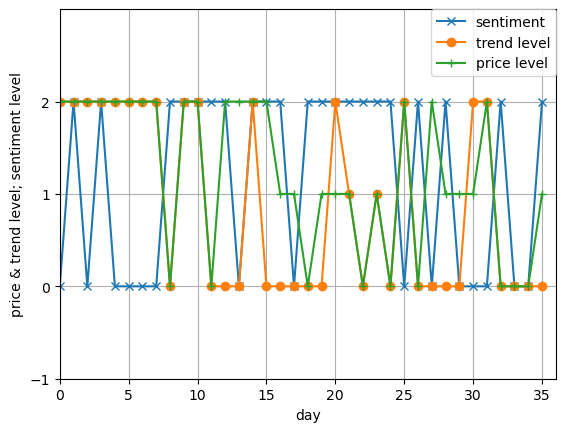

2023-03-10    5
2023-02-28    5
2023-03-08    4
2023-02-27    4
2023-03-13    3
2023-03-09    3
2023-03-06    3
2023-03-05    3
2023-03-03    3
2023-03-07    2
2023-03-02    2
2023-03-01    2
2023-02-26    2
2023-03-12    1
2023-03-11    1
2023-03-04    1
Name: date, dtype: int64


16it [00:08,  1.86it/s]


[1, 1, 2, 2, 2, 0, 0, 2, 2, 2, 1, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 1, 0, 2, 2, 1, 2, 2, 1, 2, 2, 0, 2, 2, 2, 2]
Hoya Capital 1


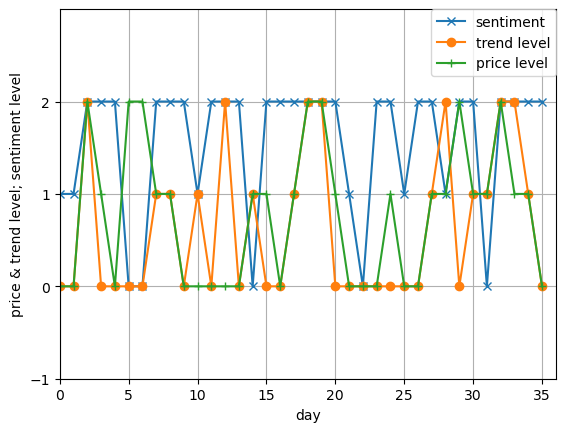

2023-03-01    6
2023-03-07    5
2023-03-10    4
2023-03-03    4
2023-03-02    4
2023-02-28    4
2023-03-08    3
2023-03-06    3
2023-03-14    2
2023-03-04    2
2023-02-27    2
2023-02-26    2
2023-03-05    1
Name: date, dtype: int64


13it [00:06,  2.02it/s]


[0, 0, 2, 2, 0, 2, 2, 2, 2, 0, 2, 2, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 0, 2, 2, 2, 0, 2, 2]
Stephen Simpson 1


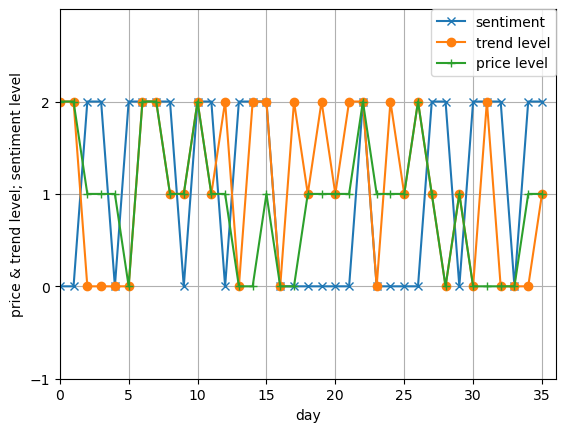

2023-03-02    5
2023-02-28    5
2023-02-26    5
2023-03-08    3
2023-03-06    3
2023-03-09    2
2023-03-07    2
2023-03-01    2
2023-03-13    1
2023-03-12    1
2023-03-10    1
2023-03-05    1
2023-03-03    1
2023-02-27    1
Name: date, dtype: int64


2it [00:01,  1.78it/s]

Got error from yahoo api for ticker BEI.UN.TO, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}
- BEI.UN.TO: No timezone found, symbol may be delisted


14it [00:04,  3.20it/s]


[2, 2, 0, 0, 0, 0, 2, 1, 1, 1, 2, 2, 2, 1, 1, 0, 0, 2, 2, 0, 0, 1, 0]
Trapping Value 1


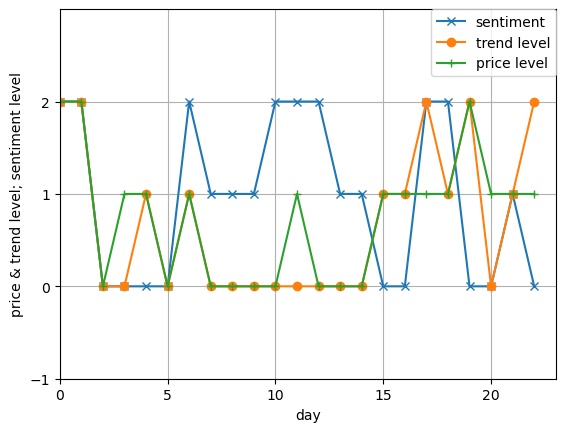

2023-03-07    4
2023-02-27    4
2023-03-12    3
2023-03-02    3
2023-03-13    2
2023-03-10    2
2023-03-09    2
2023-03-08    2
2023-03-06    2
2023-03-05    2
2023-03-03    2
2023-02-28    2
Name: date, dtype: int64


12it [00:05,  2.26it/s]

[0, 0, 2, 2, 0, 2, 2, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0]
Taylor Dart 1


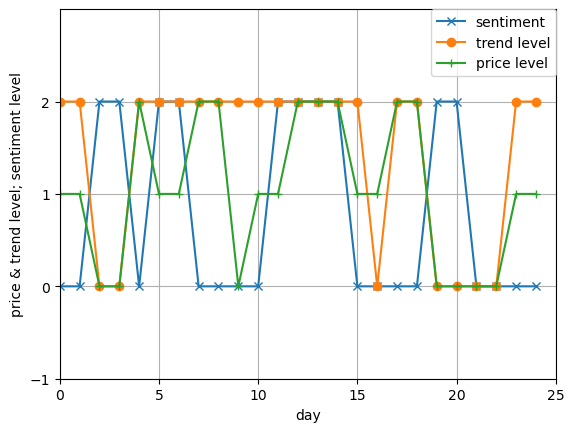

2023-03-05    3
2023-02-28    3
2023-02-27    3
2023-03-10    2
2023-03-08    2
2023-03-02    2
2023-03-13    1
2023-03-12    1
2023-03-11    1
2023-03-09    1
2023-03-07    1
2023-03-06    1
2023-03-04    1
2023-03-03    1
2023-03-01    1
2023-02-26    1
Name: date, dtype: int64


16it [00:04,  3.79it/s]


[0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Gen Alpha 1


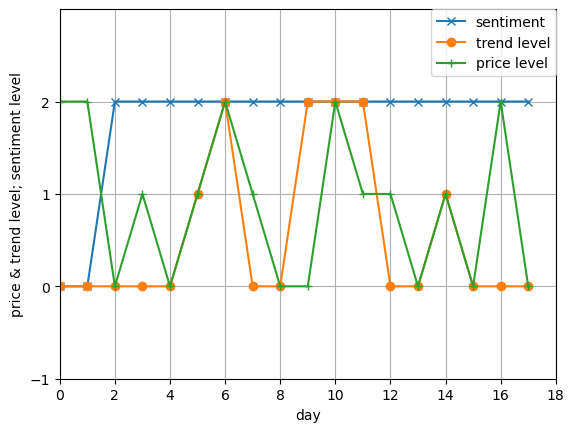

2023-03-06    8
2023-03-13    2
2023-03-03    1
2023-03-02    1
2023-02-28    1
2023-02-27    1
Name: date, dtype: int64


6it [00:01,  3.16it/s]


[0, 0, 0, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2]
Nick Ackerman 1


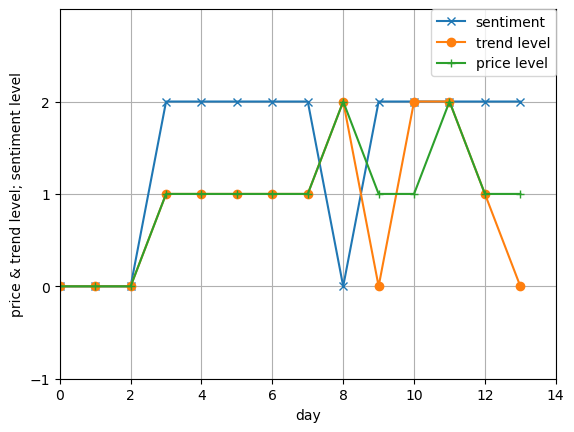

2023-03-02    5
2023-03-13    4
2023-03-08    4
2023-03-01    4
2023-02-27    4
2023-03-09    3
2023-03-07    3
2023-03-06    3
2023-02-28    3
2023-02-26    3
2023-03-10    2
2023-03-05    2
2023-03-03    2
2023-03-11    1
2023-03-12    1
2023-03-04    1
Name: date, dtype: int64


2it [00:01,  1.94it/s]

^SPX: Period '1mo' is invalid, must be one of ['1d', '5d']


16it [00:07,  2.10it/s]

[0, 2, 0, 2, 0, 0, 0, 0, 2, 2, 2, 2, 2, 0, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 0, 2, 0, 2, 0, 0, 0, 2, 0, 0, 2]
Daniel Jones 2


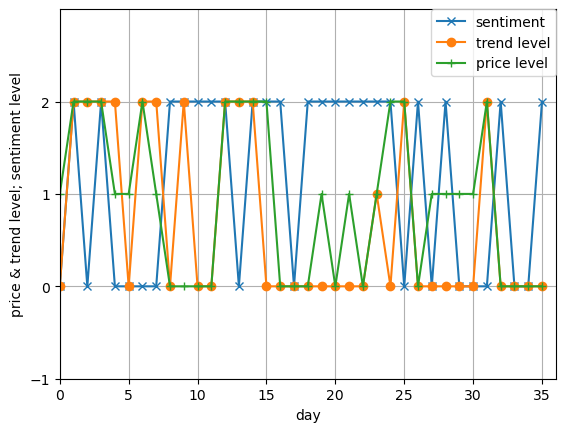

2023-03-10    5
2023-02-28    5
2023-03-08    4
2023-02-27    4
2023-03-13    3
2023-03-09    3
2023-03-06    3
2023-03-05    3
2023-03-03    3
2023-03-07    2
2023-03-02    2
2023-03-01    2
2023-02-26    2
2023-03-12    1
2023-03-11    1
2023-03-04    1
Name: date, dtype: int64


16it [00:07,  2.22it/s]


[1, 1, 2, 2, 2, 0, 0, 2, 2, 2, 1, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 1, 0, 2, 2, 1, 2, 2, 1, 2, 2, 0, 2, 2, 2, 2]
Hoya Capital 2


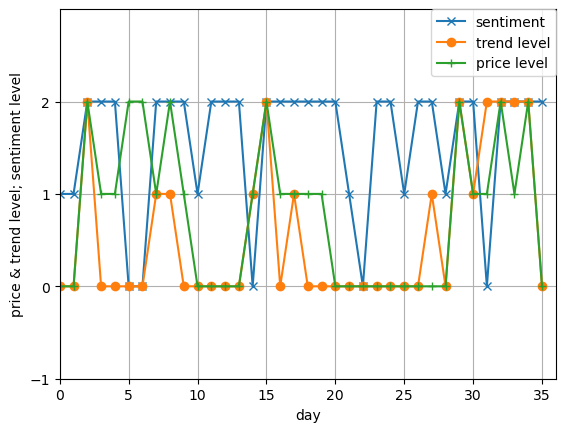

2023-03-01    6
2023-03-07    5
2023-03-10    4
2023-03-03    4
2023-03-02    4
2023-02-28    4
2023-03-08    3
2023-03-06    3
2023-03-14    2
2023-03-04    2
2023-02-27    2
2023-02-26    2
2023-03-05    1
Name: date, dtype: int64


13it [00:06,  2.04it/s]


[0, 0, 2, 2, 0, 2, 2, 2, 2, 0, 2, 2, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 0, 2, 2, 2, 0, 2, 2]
Stephen Simpson 2


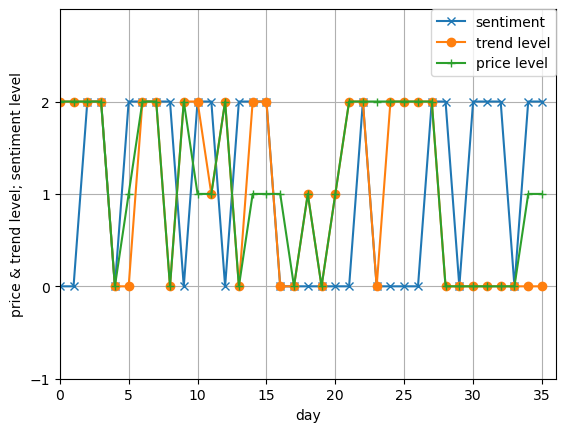

2023-03-02    5
2023-02-28    5
2023-02-26    5
2023-03-08    3
2023-03-06    3
2023-03-09    2
2023-03-07    2
2023-03-01    2
2023-03-13    1
2023-03-12    1
2023-03-10    1
2023-03-05    1
2023-03-03    1
2023-02-27    1
Name: date, dtype: int64


2it [00:01,  1.74it/s]

Got error from yahoo api for ticker BEI.UN.TO, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}
- BEI.UN.TO: No timezone found, symbol may be delisted


14it [00:05,  2.79it/s]


[2, 2, 0, 0, 0, 0, 2, 1, 1, 1, 2, 2, 2, 1, 1, 0, 0, 2, 2, 0, 0, 1, 0]
Trapping Value 2


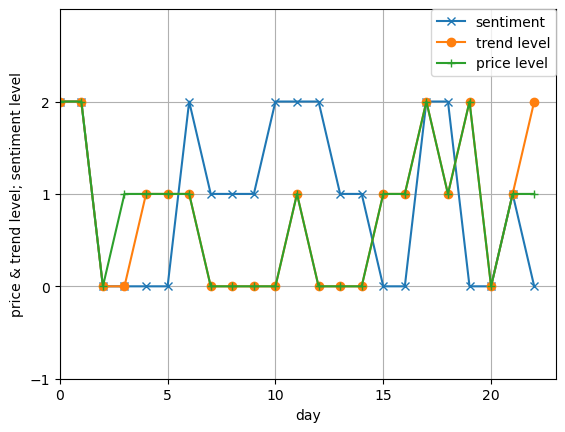

2023-03-07    4
2023-02-27    4
2023-03-12    3
2023-03-02    3
2023-03-13    2
2023-03-10    2
2023-03-09    2
2023-03-08    2
2023-03-06    2
2023-03-05    2
2023-03-03    2
2023-02-28    2
Name: date, dtype: int64


12it [00:04,  2.80it/s]

[0, 0, 2, 2, 0, 2, 2, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0]
Taylor Dart 2


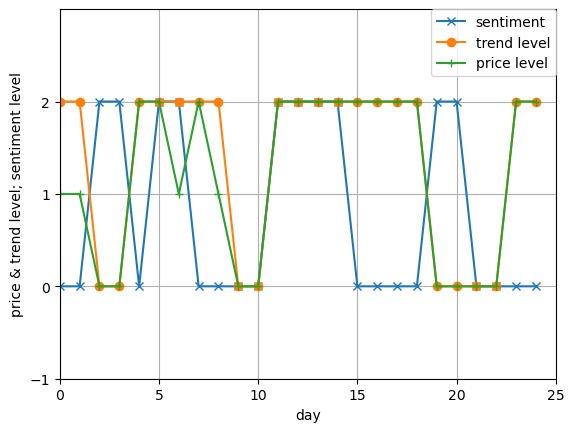

2023-03-05    3
2023-02-28    3
2023-02-27    3
2023-03-10    2
2023-03-08    2
2023-03-02    2
2023-03-13    1
2023-03-12    1
2023-03-11    1
2023-03-09    1
2023-03-07    1
2023-03-06    1
2023-03-04    1
2023-03-03    1
2023-03-01    1
2023-02-26    1
Name: date, dtype: int64


16it [00:03,  4.22it/s]


[0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Gen Alpha 2


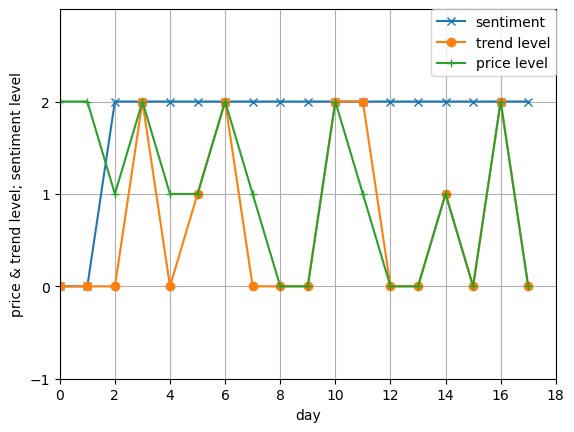

2023-03-06    8
2023-03-13    2
2023-03-03    1
2023-03-02    1
2023-02-28    1
2023-02-27    1
Name: date, dtype: int64


6it [00:01,  3.13it/s]


[0, 0, 0, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2]
Nick Ackerman 2


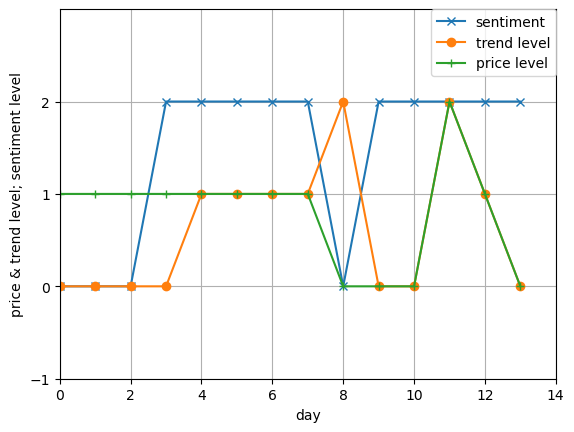

2023-03-02    5
2023-03-13    4
2023-03-08    4
2023-03-01    4
2023-02-27    4
2023-03-09    3
2023-03-07    3
2023-03-06    3
2023-02-28    3
2023-02-26    3
2023-03-10    2
2023-03-05    2
2023-03-03    2
2023-03-11    1
2023-03-12    1
2023-03-04    1
Name: date, dtype: int64


2it [00:01,  1.97it/s]

^SPX: Period '1mo' is invalid, must be one of ['1d', '5d']


16it [00:06,  2.36it/s]

[0, 2, 0, 2, 0, 0, 0, 0, 2, 2, 2, 2, 2, 0, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 0, 2, 0, 2, 0, 0, 0, 2, 0, 0, 2]
Daniel Jones 3


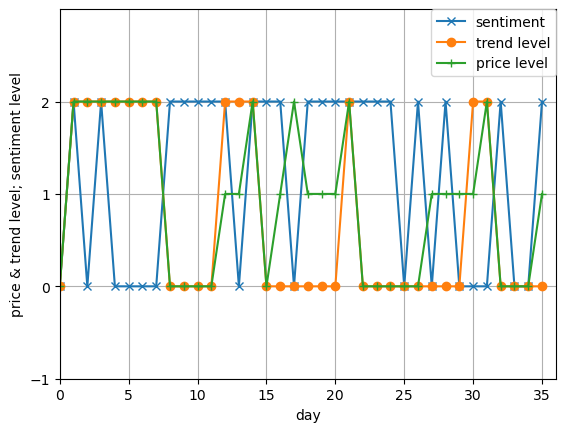

2023-03-10    5
2023-02-28    5
2023-03-08    4
2023-02-27    4
2023-03-13    3
2023-03-09    3
2023-03-06    3
2023-03-05    3
2023-03-03    3
2023-03-07    2
2023-03-02    2
2023-03-01    2
2023-02-26    2
2023-03-12    1
2023-03-11    1
2023-03-04    1
Name: date, dtype: int64


16it [00:08,  1.85it/s]


[1, 1, 2, 2, 2, 0, 0, 2, 2, 2, 1, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 1, 0, 2, 2, 1, 2, 2, 1, 2, 2, 0, 2, 2, 2, 2]
Hoya Capital 3


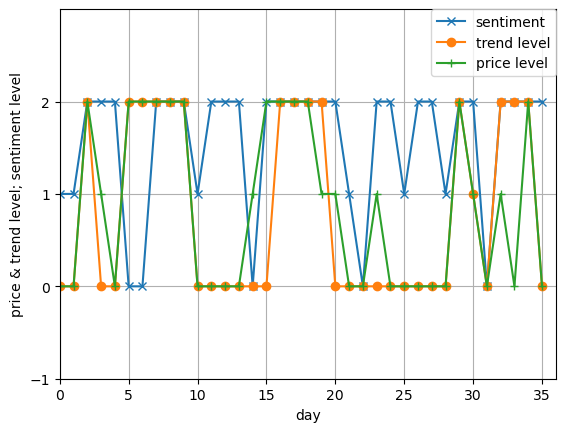

2023-03-01    6
2023-03-07    5
2023-03-10    4
2023-03-03    4
2023-03-02    4
2023-02-28    4
2023-03-08    3
2023-03-06    3
2023-03-14    2
2023-03-04    2
2023-02-27    2
2023-02-26    2
2023-03-05    1
Name: date, dtype: int64


13it [00:06,  1.86it/s]


[0, 0, 2, 2, 0, 2, 2, 2, 2, 0, 2, 2, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 0, 2, 2, 2, 0, 2, 2]
Stephen Simpson 3


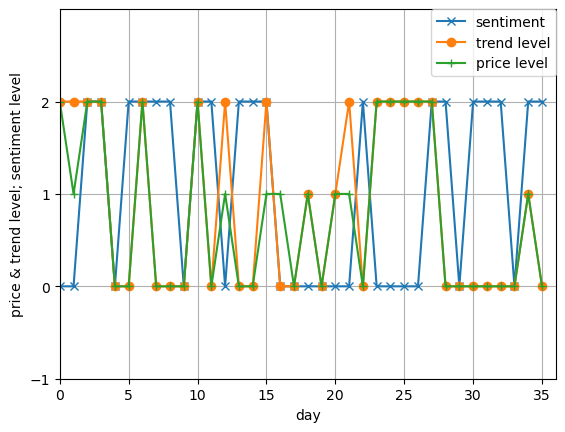

2023-03-02    5
2023-02-28    5
2023-02-26    5
2023-03-08    3
2023-03-06    3
2023-03-09    2
2023-03-07    2
2023-03-01    2
2023-03-13    1
2023-03-12    1
2023-03-10    1
2023-03-05    1
2023-03-03    1
2023-02-27    1
Name: date, dtype: int64


2it [00:01,  1.28it/s]

Got error from yahoo api for ticker BEI.UN.TO, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}
- BEI.UN.TO: No timezone found, symbol may be delisted


14it [00:04,  2.88it/s]


[2, 2, 0, 0, 0, 0, 2, 1, 1, 1, 2, 2, 2, 1, 1, 0, 0, 2, 2, 0, 0, 1, 0]
Trapping Value 3


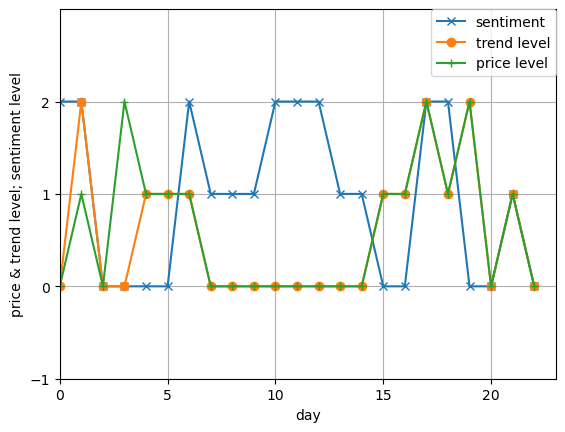

2023-03-07    4
2023-02-27    4
2023-03-12    3
2023-03-02    3
2023-03-13    2
2023-03-10    2
2023-03-09    2
2023-03-08    2
2023-03-06    2
2023-03-05    2
2023-03-03    2
2023-02-28    2
Name: date, dtype: int64


12it [00:04,  2.51it/s]

[0, 0, 2, 2, 0, 2, 2, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0]
Taylor Dart 3


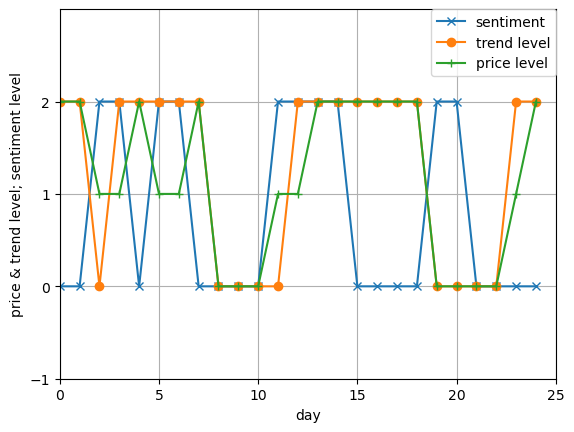

2023-03-05    3
2023-02-28    3
2023-02-27    3
2023-03-10    2
2023-03-08    2
2023-03-02    2
2023-03-13    1
2023-03-12    1
2023-03-11    1
2023-03-09    1
2023-03-07    1
2023-03-06    1
2023-03-04    1
2023-03-03    1
2023-03-01    1
2023-02-26    1
Name: date, dtype: int64


16it [00:05,  2.86it/s]

[0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Gen Alpha 3


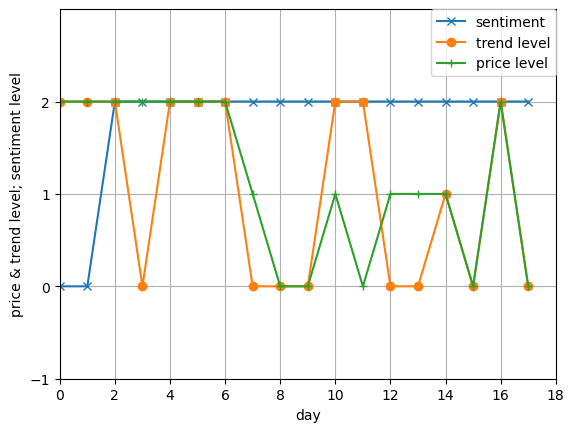

2023-03-06    8
2023-03-13    2
2023-03-03    1
2023-03-02    1
2023-02-28    1
2023-02-27    1
Name: date, dtype: int64


6it [00:02,  2.14it/s]

[0, 0, 0, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2]
Nick Ackerman 3


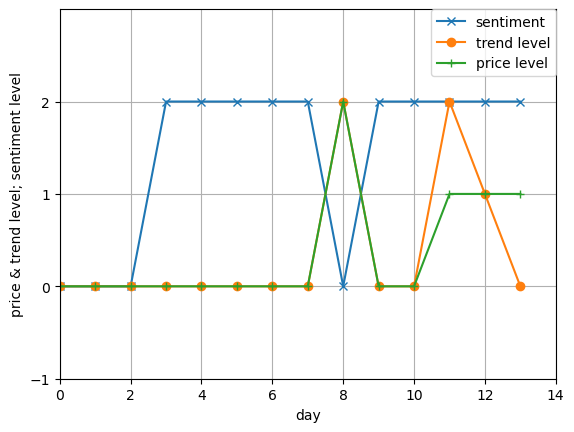

2023-03-02    5
2023-03-13    4
2023-03-08    4
2023-03-01    4
2023-02-27    4
2023-03-09    3
2023-03-07    3
2023-03-06    3
2023-02-28    3
2023-02-26    3
2023-03-10    2
2023-03-05    2
2023-03-03    2
2023-03-11    1
2023-03-12    1
2023-03-04    1
Name: date, dtype: int64


2it [00:01,  1.81it/s]

^SPX: Period '1mo' is invalid, must be one of ['1d', '5d']


16it [00:08,  1.85it/s]


[0, 2, 0, 2, 0, 0, 0, 0, 2, 2, 2, 2, 2, 0, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 0, 2, 0, 2, 0, 0, 0, 2, 0, 0, 2]
Daniel Jones 4


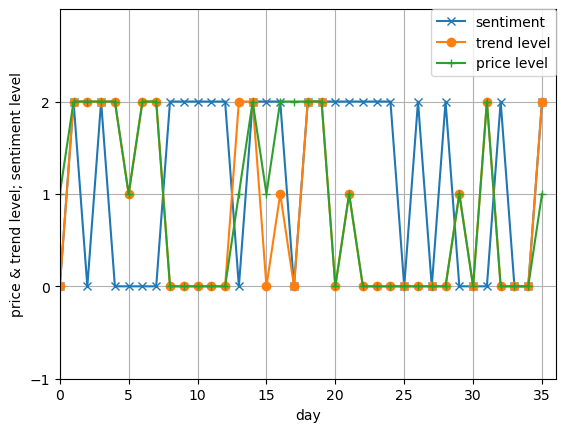

2023-03-10    5
2023-02-28    5
2023-03-08    4
2023-02-27    4
2023-03-13    3
2023-03-09    3
2023-03-06    3
2023-03-05    3
2023-03-03    3
2023-03-07    2
2023-03-02    2
2023-03-01    2
2023-02-26    2
2023-03-12    1
2023-03-11    1
2023-03-04    1
Name: date, dtype: int64


16it [00:09,  1.75it/s]

[1, 1, 2, 2, 2, 0, 0, 2, 2, 2, 1, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 1, 0, 2, 2, 1, 2, 2, 1, 2, 2, 0, 2, 2, 2, 2]
Hoya Capital 4


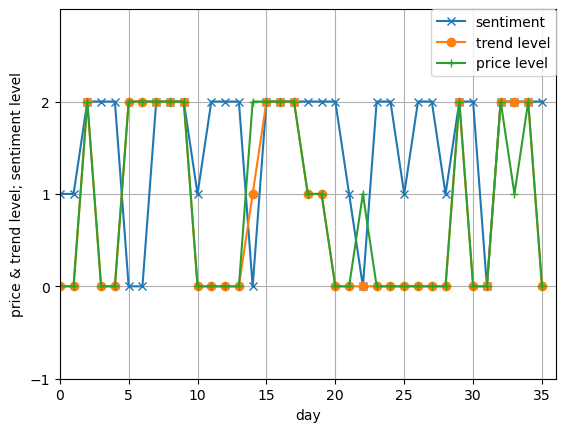

2023-03-01    6
2023-03-07    5
2023-03-10    4
2023-03-03    4
2023-03-02    4
2023-02-28    4
2023-03-08    3
2023-03-06    3
2023-03-14    2
2023-03-04    2
2023-02-27    2
2023-02-26    2
2023-03-05    1
Name: date, dtype: int64


13it [00:08,  1.46it/s]

[0, 0, 2, 2, 0, 2, 2, 2, 2, 0, 2, 2, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 0, 2, 2, 2, 0, 2, 2]
Stephen Simpson 4


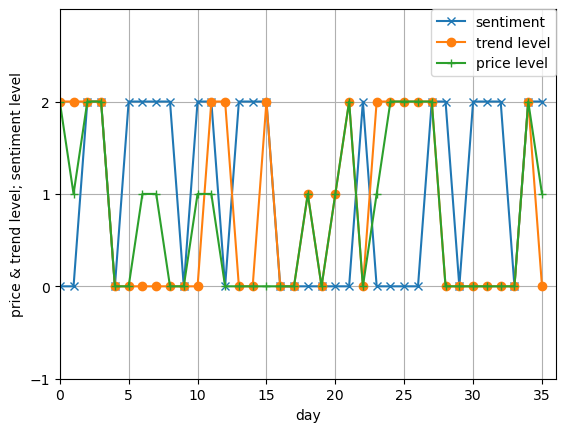

2023-03-02    5
2023-02-28    5
2023-02-26    5
2023-03-08    3
2023-03-06    3
2023-03-09    2
2023-03-07    2
2023-03-01    2
2023-03-13    1
2023-03-12    1
2023-03-10    1
2023-03-05    1
2023-03-03    1
2023-02-27    1
Name: date, dtype: int64


2it [00:01,  1.61it/s]

Got error from yahoo api for ticker BEI.UN.TO, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}
- BEI.UN.TO: No timezone found, symbol may be delisted


14it [00:05,  2.56it/s]

[2, 2, 0, 0, 0, 0, 2, 1, 1, 1, 2, 2, 2, 1, 1, 0, 0, 2, 2, 0, 0, 1, 0]
Trapping Value 4


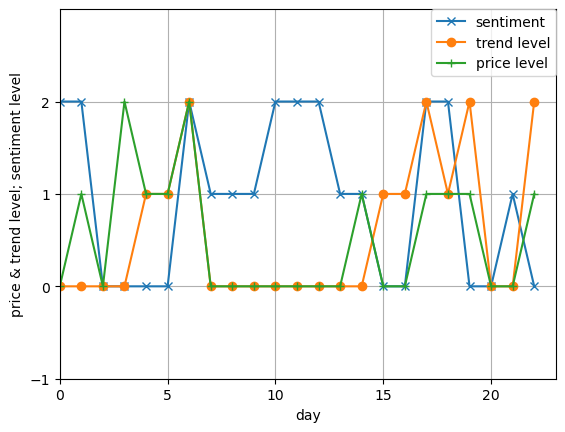

2023-03-07    4
2023-02-27    4
2023-03-12    3
2023-03-02    3
2023-03-13    2
2023-03-10    2
2023-03-09    2
2023-03-08    2
2023-03-06    2
2023-03-05    2
2023-03-03    2
2023-02-28    2
Name: date, dtype: int64


12it [00:04,  2.47it/s]

[0, 0, 2, 2, 0, 2, 2, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0]
Taylor Dart 4


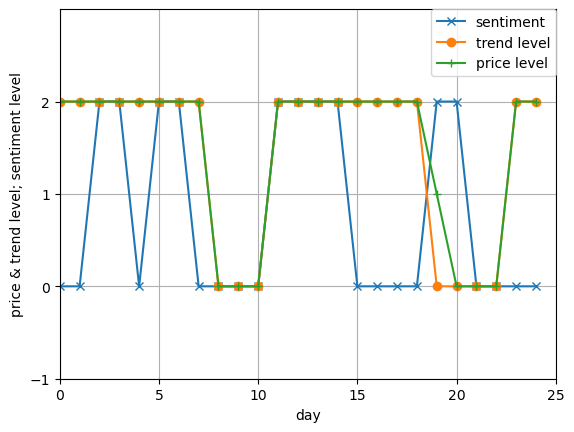

2023-03-05    3
2023-02-28    3
2023-02-27    3
2023-03-10    2
2023-03-08    2
2023-03-02    2
2023-03-13    1
2023-03-12    1
2023-03-11    1
2023-03-09    1
2023-03-07    1
2023-03-06    1
2023-03-04    1
2023-03-03    1
2023-03-01    1
2023-02-26    1
Name: date, dtype: int64


16it [00:04,  3.40it/s]


[0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Gen Alpha 4


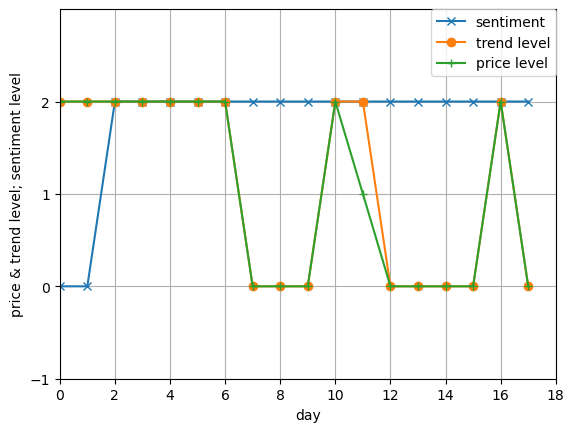

2023-03-06    8
2023-03-13    2
2023-03-03    1
2023-03-02    1
2023-02-28    1
2023-02-27    1
Name: date, dtype: int64


6it [00:02,  2.82it/s]

[0, 0, 0, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2]
Nick Ackerman 4


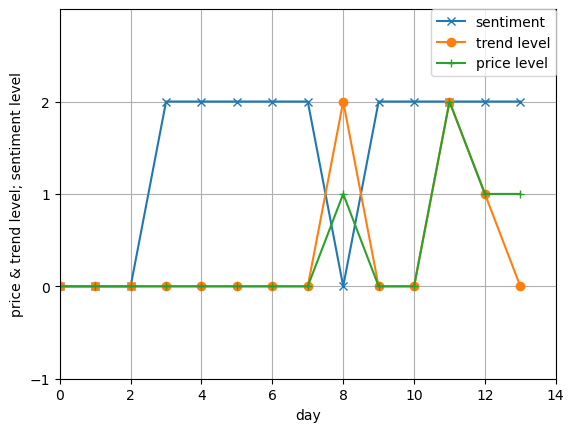

2023-03-02    5
2023-03-13    4
2023-03-08    4
2023-03-01    4
2023-02-27    4
2023-03-09    3
2023-03-07    3
2023-03-06    3
2023-02-28    3
2023-02-26    3
2023-03-10    2
2023-03-05    2
2023-03-03    2
2023-03-11    1
2023-03-12    1
2023-03-04    1
Name: date, dtype: int64


2it [00:01,  2.00it/s]

^SPX: Period '1mo' is invalid, must be one of ['1d', '5d']


16it [00:05,  2.68it/s]


[0, 2, 0, 2, 0, 0, 0, 0, 2, 2, 2, 2, 2, 0, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 0, 2, 0, 2, 0, 0, 0, 2, 0, 0, 2]
Daniel Jones 5


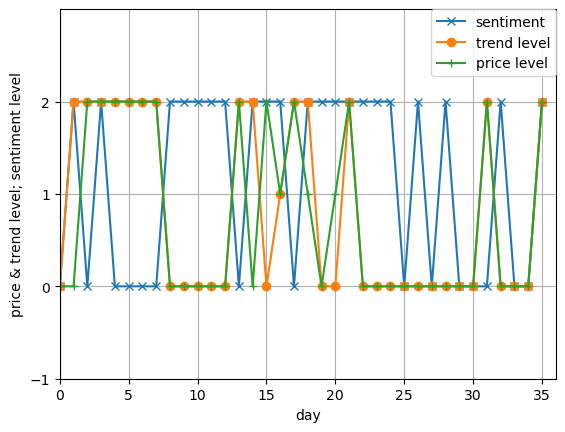

2023-03-10    5
2023-02-28    5
2023-03-08    4
2023-02-27    4
2023-03-13    3
2023-03-09    3
2023-03-06    3
2023-03-05    3
2023-03-03    3
2023-03-07    2
2023-03-02    2
2023-03-01    2
2023-02-26    2
2023-03-12    1
2023-03-11    1
2023-03-04    1
Name: date, dtype: int64


16it [00:07,  2.03it/s]

[1, 1, 2, 2, 2, 0, 0, 2, 2, 2, 1, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 1, 0, 2, 2, 1, 2, 2, 1, 2, 2, 0, 2, 2, 2, 2]
Hoya Capital 5


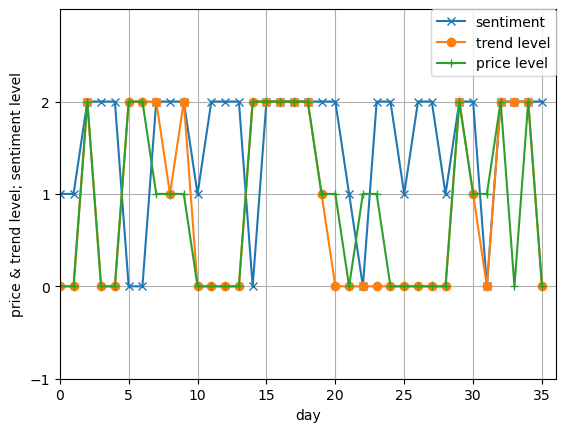

2023-03-01    6
2023-03-07    5
2023-03-10    4
2023-03-03    4
2023-03-02    4
2023-02-28    4
2023-03-08    3
2023-03-06    3
2023-03-14    2
2023-03-04    2
2023-02-27    2
2023-02-26    2
2023-03-05    1
Name: date, dtype: int64


13it [00:07,  1.83it/s]

[0, 0, 2, 2, 0, 2, 2, 2, 2, 0, 2, 2, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 0, 2, 2, 2, 0, 2, 2]
Stephen Simpson 5


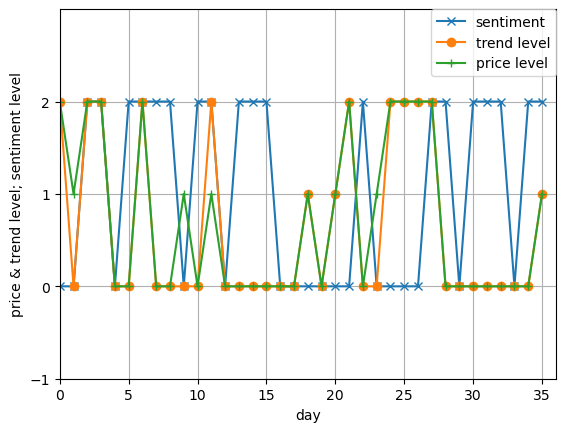

2023-03-02    5
2023-02-28    5
2023-02-26    5
2023-03-08    3
2023-03-06    3
2023-03-09    2
2023-03-07    2
2023-03-01    2
2023-03-13    1
2023-03-12    1
2023-03-10    1
2023-03-05    1
2023-03-03    1
2023-02-27    1
Name: date, dtype: int64


1it [00:00,  2.06it/s]

Got error from yahoo api for ticker BEI.UN.TO, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}
- BEI.UN.TO: No timezone found, symbol may be delisted


14it [00:05,  2.50it/s]

[2, 2, 0, 0, 0, 0, 2, 1, 1, 1, 2, 2, 2, 1, 1, 0, 0, 2, 2, 0, 0, 1, 0]
Trapping Value 5


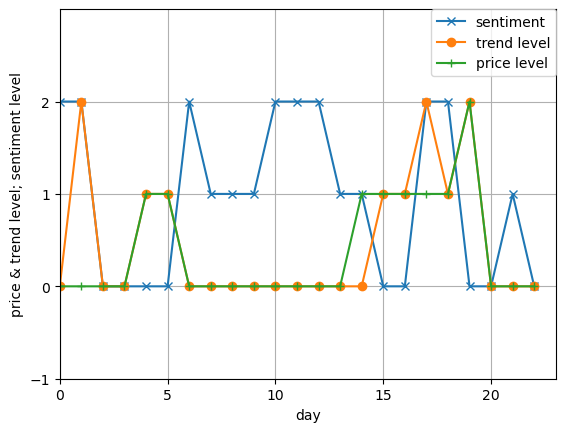

2023-03-07    4
2023-02-27    4
2023-03-12    3
2023-03-02    3
2023-03-13    2
2023-03-10    2
2023-03-09    2
2023-03-08    2
2023-03-06    2
2023-03-05    2
2023-03-03    2
2023-02-28    2
Name: date, dtype: int64


12it [00:05,  2.06it/s]

[0, 0, 2, 2, 0, 2, 2, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0]
Taylor Dart 5


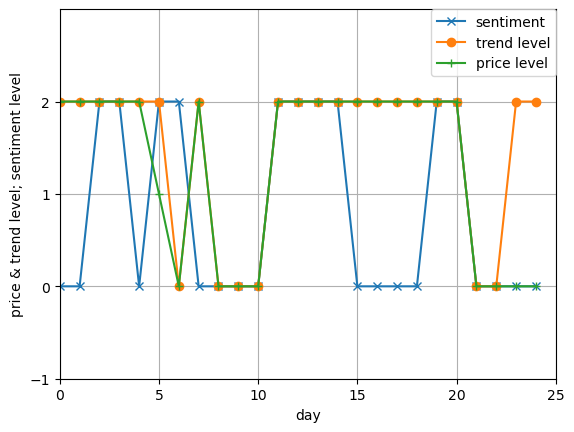

2023-03-05    3
2023-02-28    3
2023-02-27    3
2023-03-10    2
2023-03-08    2
2023-03-02    2
2023-03-13    1
2023-03-12    1
2023-03-11    1
2023-03-09    1
2023-03-07    1
2023-03-06    1
2023-03-04    1
2023-03-03    1
2023-03-01    1
2023-02-26    1
Name: date, dtype: int64


16it [00:04,  3.41it/s]


[0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Gen Alpha 5


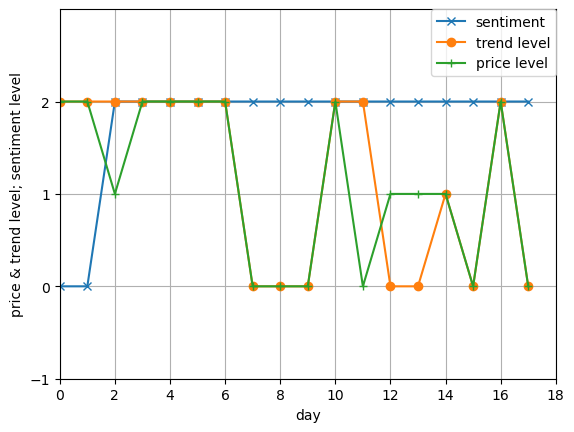

2023-03-06    8
2023-03-13    2
2023-03-03    1
2023-03-02    1
2023-02-28    1
2023-02-27    1
Name: date, dtype: int64


6it [00:01,  3.03it/s]

[0, 0, 0, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2]
Nick Ackerman 5


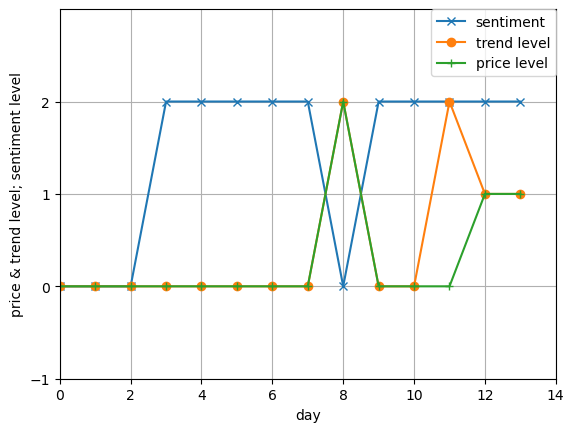

In [323]:
sa_eval_df =  pd.DataFrame(columns = ['author', 'time_window', 
                                 'acc_trend','acc_price',
                                 'p_0_trend','p_1_trend','p_2_trend',
                                 'p_0_price','p_1_price','p_2_price'])
authors = sa_df['author'].value_counts()
for i in range(1,6):
    for aut, cnt_aut in authors.iteritems():
        acc_trend, acc_price ,trend_arr, price_arr, sen_arr = evaluate_sa(aut,i,0.02,0.01)
        sa_eval_df = sa_eval_df.append({'author':aut,'time_window':i,
                              'acc_trend':acc_trend,'acc_price':acc_price,
                              'p_0_trend':con_prob(0,trend_arr,sen_arr),'p_1_trend':con_prob(1,trend_arr,sen_arr),'p_2_trend':con_prob(2,trend_arr,sen_arr),
                              'p_0_price':con_prob(0,price_arr,sen_arr),'p_1_price':con_prob(1,price_arr,sen_arr),'p_2_price':con_prob(2,price_arr,sen_arr)
                             }, ignore_index = True)
        print(aut, i)
        plot(sen_arr,trend_arr, price_arr)

In [325]:
sa_eval_df.to_csv('../data/seeking_alpha_eval.csv')

2023-03-01    42
2023-02-28    32
2023-03-06    25
2023-03-09    18
2023-03-07    12
2023-02-27    11
2023-03-08    11
2023-03-10    10
2023-03-02     8
2023-02-26     6
2023-03-13     3
Name: date, dtype: int64


2it [00:04,  2.28s/it]

TWTR: No data found, symbol may be delisted


4it [00:08,  1.97s/it]

Got error from yahoo api for ticker CERN, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}
- CERN: No timezone found, symbol may be delisted
TWTR: No data found, symbol may be delisted
Got error from yahoo api for ticker FB, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}
- FB: No timezone found, symbol may be delisted


8it [00:12,  1.23s/it]

Got error from yahoo api for ticker CERN, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}
- CERN: No timezone found, symbol may be delisted
Got error from yahoo api for ticker HRS, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}
- HRS: No timezone found, symbol may be delisted


10it [00:14,  1.00it/s]

TWTR: No data found, symbol may be delisted


11it [00:14,  1.33s/it]

Reuters 1


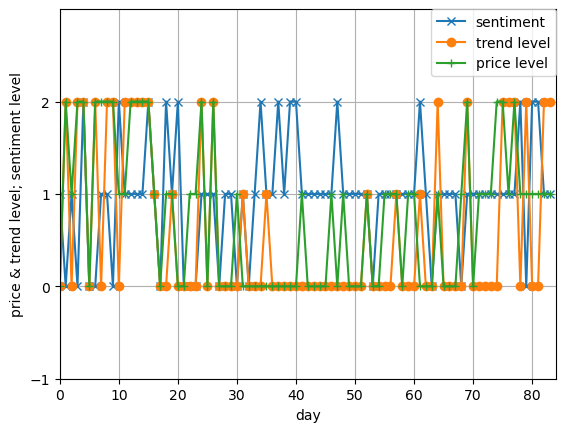

2023-03-01    29
2023-03-09    27
2023-02-28    20
2023-03-06    20
2023-03-08    11
2023-02-26    10
2023-03-02     6
2023-02-27     3
2023-03-07     3
2023-03-10     3
Name: date, dtype: int64


0it [00:00, ?it/s]

Got error from yahoo api for ticker FB, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}
- FB: No timezone found, symbol may be delisted
TWTR: No data found, symbol may be delisted


1it [00:01,  1.90s/it]

Got error from yahoo api for ticker DISCA, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}
- DISCA: No timezone found, symbol may be delisted
Got error from yahoo api for ticker DISCK, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}
- DISCK: No timezone found, symbol may be delisted
TWTR: No data found, symbol may be delisted


2it [00:04,  2.09s/it]

TWTR: No data found, symbol may be delisted


3it [00:06,  2.17s/it]

TWTR: No data found, symbol may be delisted


5it [00:08,  1.46s/it]

TWTR: No data found, symbol may be delisted


7it [00:09,  1.02s/it]

TWTR: No data found, symbol may be delisted


10it [00:11,  1.11s/it]

Got error from yahoo api for ticker HRS, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}
- HRS: No timezone found, symbol may be delisted
business 1


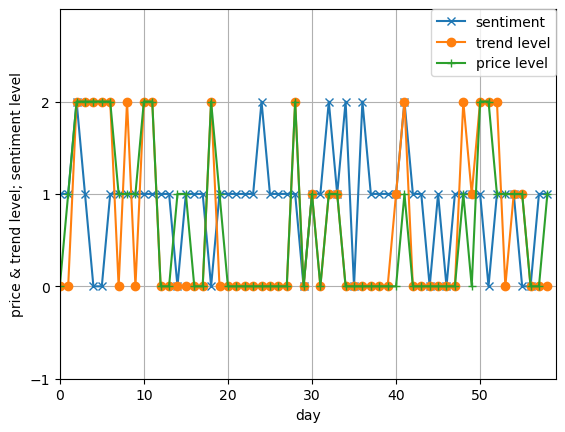

2023-02-28    18
2023-03-06    17
2023-03-08    17
2023-03-01    14
2023-02-26    11
2023-03-09     8
2023-03-07     3
2023-03-10     2
2023-02-27     1
2023-03-02     1
Name: date, dtype: int64


1it [00:01,  1.69s/it]

TWTR: No data found, symbol may be delisted


2it [00:03,  1.60s/it]

TWTR: No data found, symbol may be delisted


5it [00:08,  1.64s/it]

TWTR: No data found, symbol may be delisted
Got error from yahoo api for ticker DISCA, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}
- DISCA: No timezone found, symbol may be delisted
Got error from yahoo api for ticker DISCK, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}
- DISCK: No timezone found, symbol may be delisted


7it [00:09,  1.11s/it]

Got error from yahoo api for ticker FB, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}
- FB: No timezone found, symbol may be delisted


10it [00:10,  1.04s/it]

MarketWatch 1


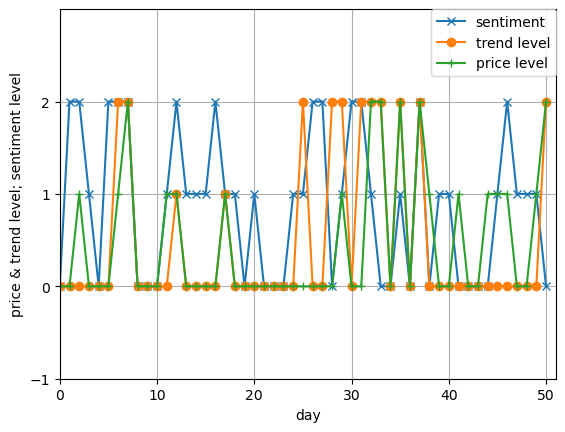

2023-02-28    18
2023-03-01    18
2023-03-06    13
2023-03-09    13
2023-03-08     5
2023-03-02     2
2023-03-07     2
2023-02-26     2
2023-03-13     2
2023-02-27     1
Name: date, dtype: int64


2it [00:02,  1.07s/it]

TWTR: No data found, symbol may be delisted


4it [00:04,  1.19s/it]

TWTR: No data found, symbol may be delisted


7it [00:06,  1.49it/s]

Got error from yahoo api for ticker FB, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}
- FB: No timezone found, symbol may be delisted
TWTR: No data found, symbol may be delisted


8it [00:06,  1.75it/s]

DDR: No data found for this date range, symbol may be delisted


10it [00:06,  1.45it/s]


YahooFinance 1


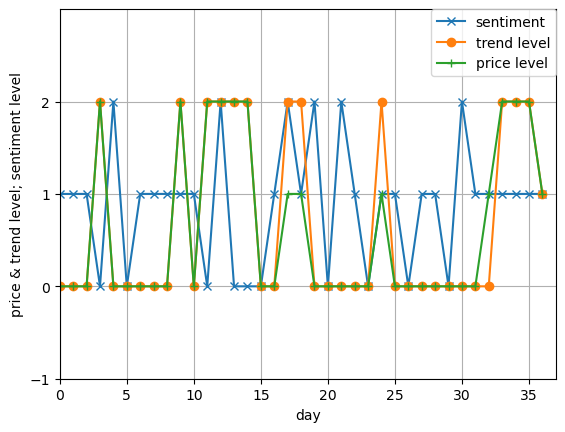

2023-03-01    14
2023-03-06    12
2023-02-28    10
2023-03-02     5
2023-03-08     5
2023-02-26     4
2023-03-07     3
2023-02-27     2
2023-03-09     1
2023-03-10     1
Name: date, dtype: int64


0it [00:00, ?it/s]

TWTR: No data found, symbol may be delisted


1it [00:01,  1.76s/it]

TWTR: No data found, symbol may be delisted


2it [00:02,  1.12s/it]

Got error from yahoo api for ticker FB, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}
- FB: No timezone found, symbol may be delisted


4it [00:03,  1.28it/s]

TWTR: No data found, symbol may be delisted
TWTR: No data found, symbol may be delisted


7it [00:05,  1.69it/s]

TWTR: No data found, symbol may be delisted


9it [00:05,  2.65it/s]

TWTR: No data found, symbol may be delisted


10it [00:05,  1.69it/s]


Forbes 1


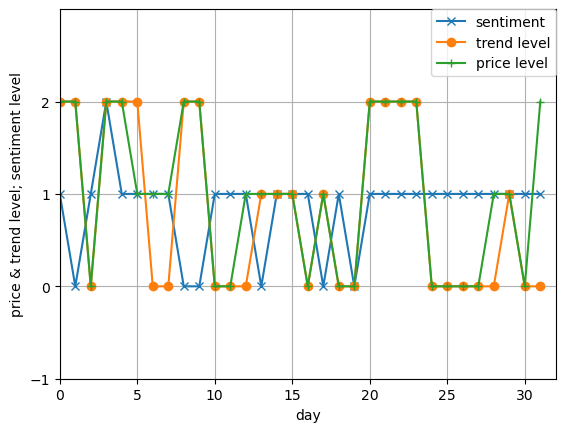

2023-03-01    11
2023-02-28     7
2023-03-08     7
2023-03-06     5
2023-03-09     5
2023-02-26     2
2023-02-27     2
2023-03-02     1
2023-03-07     1
2023-03-10     1
Name: date, dtype: int64


0it [00:00, ?it/s]

TWTR: No data found, symbol may be delisted


1it [00:01,  1.06s/it]

Got error from yahoo api for ticker FB, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}
- FB: No timezone found, symbol may be delisted


2it [00:02,  1.22s/it]

TWTR: No data found, symbol may be delisted


4it [00:03,  1.12it/s]

TWTR: No data found, symbol may be delisted


5it [00:04,  1.20it/s]

TWTR: No data found, symbol may be delisted


7it [00:05,  1.87it/s]

TWTR: No data found, symbol may be delisted


10it [00:05,  1.80it/s]


WSJ 1


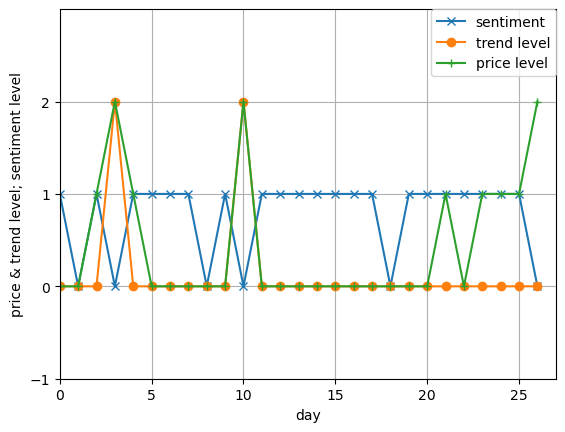

2023-03-01    8
2023-02-28    7
2023-03-08    7
2023-03-06    5
2023-02-26    3
2023-03-02    3
2023-02-27    2
2023-03-09    2
Name: date, dtype: int64


0it [00:00, ?it/s]

TWTR: No data found, symbol may be delisted


1it [00:00,  1.38it/s]

TWTR: No data found, symbol may be delisted


2it [00:01,  1.63it/s]

TWTR: No data found, symbol may be delisted


4it [00:02,  2.12it/s]

TWTR: No data found, symbol may be delisted


6it [00:02,  3.32it/s]

TWTR: No data found, symbol may be delisted


8it [00:03,  2.61it/s]

TechCrunch 1


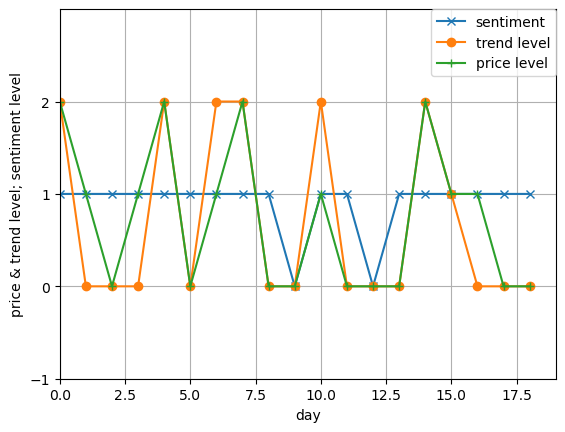

2023-03-01    14
2023-03-06     9
2023-02-28     6
2023-03-08     3
2023-03-02     2
2023-03-05     2
2023-02-26     1
Name: date, dtype: int64


0it [00:00, ?it/s]

Got error from yahoo api for ticker DISCA, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}
- DISCA: No timezone found, symbol may be delisted
Got error from yahoo api for ticker DISCK, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}
- DISCK: No timezone found, symbol may be delisted


5it [00:01,  3.88it/s]

TWTR: No data found, symbol may be delisted


7it [00:01,  3.76it/s]

GerberKawasaki 1


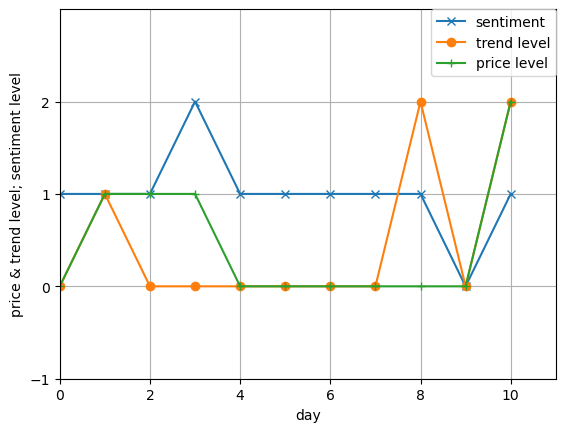

2023-03-01    8
2023-03-09    6
2023-02-28    5
2023-03-08    4
2023-03-06    3
2023-03-07    3
2023-03-10    2
2023-02-27    1
2023-03-13    1
Name: date, dtype: int64


9it [00:02,  3.30it/s]


TheStreet 1


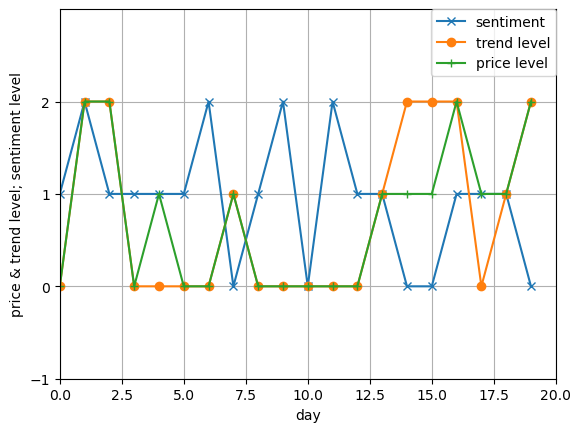

2023-03-09    4
2023-03-01    3
2023-02-27    2
2023-03-02    2
2023-03-06    2
2023-03-07    2
2023-02-28    2
2023-03-13    1
Name: date, dtype: int64


2it [00:00,  2.69it/s]

TWTR: No data found, symbol may be delisted


3it [00:01,  2.67it/s]

TWTR: No data found, symbol may be delisted


5it [00:01,  3.44it/s]

Got error from yahoo api for ticker FB, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}
- FB: No timezone found, symbol may be delisted


8it [00:02,  3.29it/s]


nytimes 1


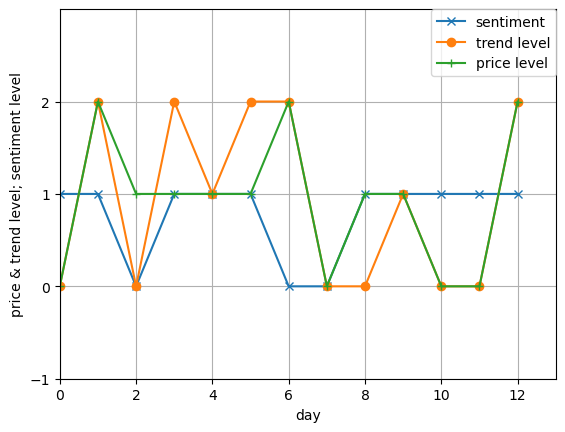

2023-03-01    4
2023-03-02    2
2023-03-06    2
2023-02-26    1
2023-02-28    1
2023-03-08    1
Name: date, dtype: int64


0it [00:00, ?it/s]

TWTR: No data found, symbol may be delisted


4it [00:00,  4.70it/s]

TWTR: No data found, symbol may be delisted


6it [00:01,  4.82it/s]

TWTR: No data found, symbol may be delisted
TheStalwart 1


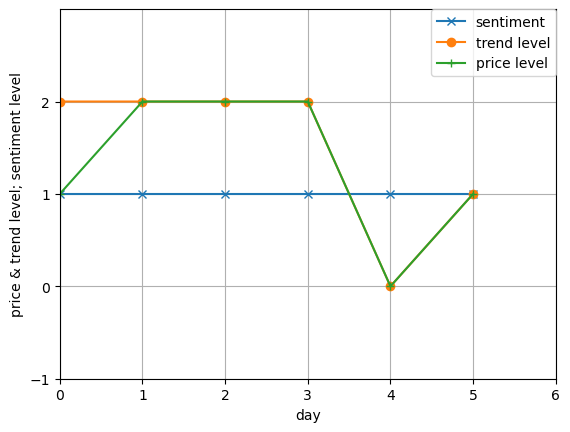

2023-02-28    2
2023-02-27    1
2023-03-01    1
2023-03-02    1
2023-03-06    1
2023-03-08    1
Name: date, dtype: int64


6it [00:00,  6.31it/s]


FT 1


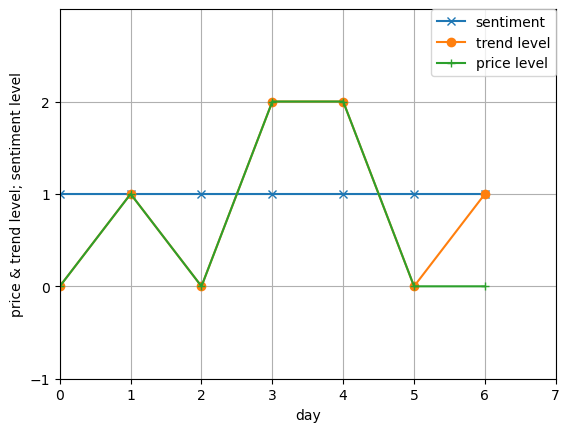

2023-03-01    2
2023-03-08    2
2023-03-09    2
2023-03-06    1
Name: date, dtype: int64


4it [00:00,  4.00it/s]

bespokeinvest 1


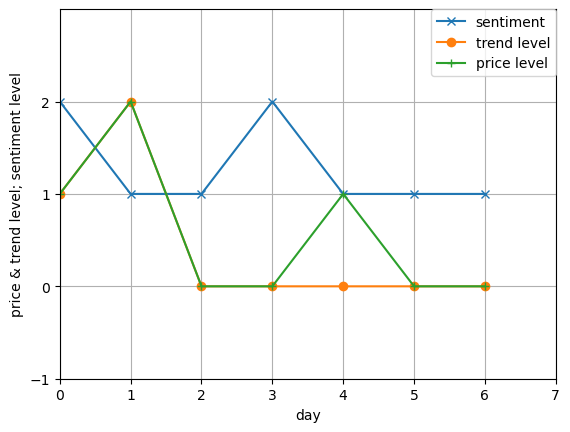

2023-03-01    2
2023-02-26    1
2023-03-06    1
2023-03-08    1
Name: date, dtype: int64


4it [00:00,  6.13it/s]

GGP: No data found for this date range, symbol may be delisted
TheEconomist 1


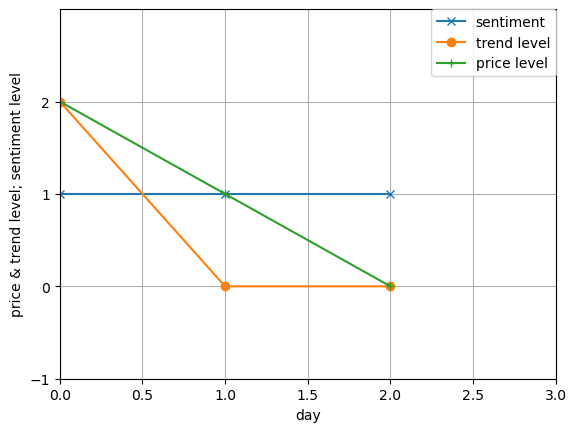

2023-03-01    42
2023-02-28    32
2023-03-06    25
2023-03-09    18
2023-03-07    12
2023-02-27    11
2023-03-08    11
2023-03-10    10
2023-03-02     8
2023-02-26     6
2023-03-13     3
Name: date, dtype: int64


2it [00:05,  2.87s/it]

TWTR: No data found, symbol may be delisted


4it [00:10,  2.38s/it]

Got error from yahoo api for ticker CERN, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}
- CERN: No timezone found, symbol may be delisted
TWTR: No data found, symbol may be delisted
Got error from yahoo api for ticker FB, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}
- FB: No timezone found, symbol may be delisted


8it [00:14,  1.33s/it]

Got error from yahoo api for ticker CERN, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}
- CERN: No timezone found, symbol may be delisted
Got error from yahoo api for ticker HRS, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}
- HRS: No timezone found, symbol may be delisted


9it [00:15,  1.23s/it]

TWTR: No data found, symbol may be delisted


11it [00:16,  1.51s/it]

Reuters 2


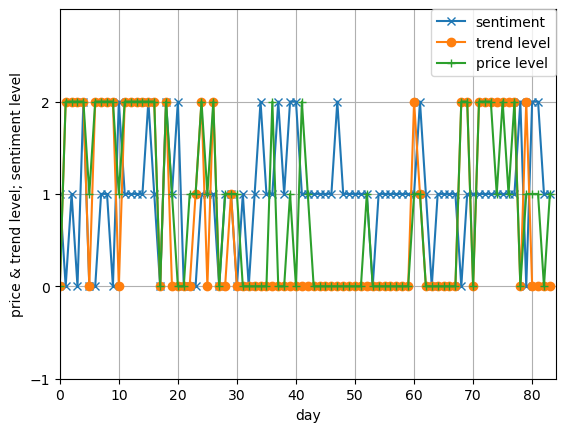

2023-03-01    29
2023-03-09    27
2023-02-28    20
2023-03-06    20
2023-03-08    11
2023-02-26    10
2023-03-02     6
2023-02-27     3
2023-03-07     3
2023-03-10     3
Name: date, dtype: int64


0it [00:00, ?it/s]

Got error from yahoo api for ticker FB, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}
- FB: No timezone found, symbol may be delisted
TWTR: No data found, symbol may be delisted


1it [00:02,  2.42s/it]

Got error from yahoo api for ticker DISCA, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}
- DISCA: No timezone found, symbol may be delisted
Got error from yahoo api for ticker DISCK, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}
- DISCK: No timezone found, symbol may be delisted
TWTR: No data found, symbol may be delisted


2it [00:04,  2.13s/it]

TWTR: No data found, symbol may be delisted


3it [00:06,  2.18s/it]

TWTR: No data found, symbol may be delisted


5it [00:09,  1.74s/it]

TWTR: No data found, symbol may be delisted


7it [00:11,  1.21s/it]

TWTR: No data found, symbol may be delisted


10it [00:13,  1.30s/it]

Got error from yahoo api for ticker HRS, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}
- HRS: No timezone found, symbol may be delisted
business 2


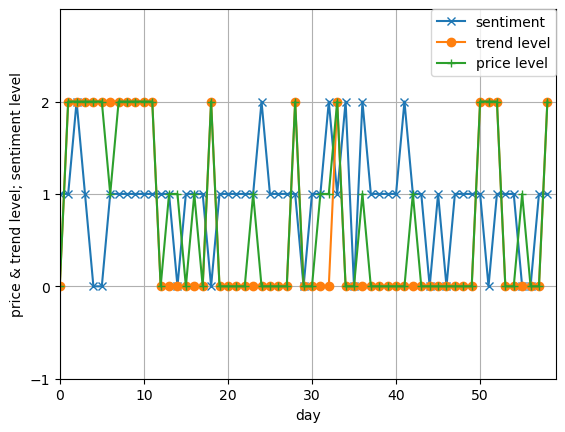

2023-02-28    18
2023-03-06    17
2023-03-08    17
2023-03-01    14
2023-02-26    11
2023-03-09     8
2023-03-07     3
2023-03-10     2
2023-02-27     1
2023-03-02     1
Name: date, dtype: int64


1it [00:01,  1.84s/it]

TWTR: No data found, symbol may be delisted


2it [00:03,  1.78s/it]

TWTR: No data found, symbol may be delisted


4it [00:06,  1.51s/it]

TWTR: No data found, symbol may be delisted
Got error from yahoo api for ticker DISCA, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}
- DISCA: No timezone found, symbol may be delisted


5it [00:08,  1.68s/it]

Got error from yahoo api for ticker DISCK, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}
- DISCK: No timezone found, symbol may be delisted


7it [00:09,  1.03s/it]

Got error from yahoo api for ticker FB, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}
- FB: No timezone found, symbol may be delisted


10it [00:10,  1.01s/it]

MarketWatch 2


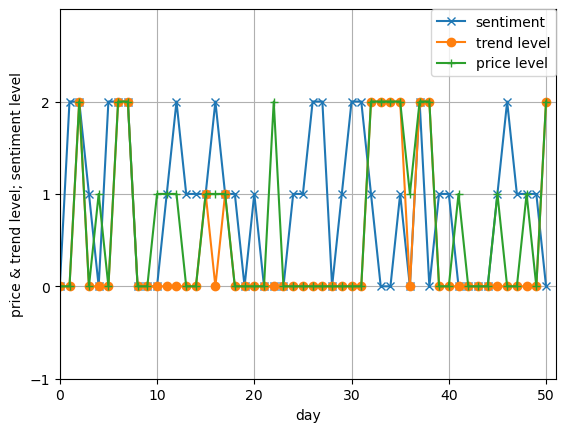

2023-02-28    18
2023-03-01    18
2023-03-06    13
2023-03-09    13
2023-03-08     5
2023-03-02     2
2023-03-07     2
2023-02-26     2
2023-03-13     2
2023-02-27     1
Name: date, dtype: int64


2it [00:03,  1.69s/it]

TWTR: No data found, symbol may be delisted


4it [00:06,  1.58s/it]

TWTR: No data found, symbol may be delisted


7it [00:07,  1.52it/s]

Got error from yahoo api for ticker FB, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}
- FB: No timezone found, symbol may be delisted
TWTR: No data found, symbol may be delisted
DDR: No data found for this date range, symbol may be delisted


10it [00:08,  1.17it/s]

YahooFinance 2


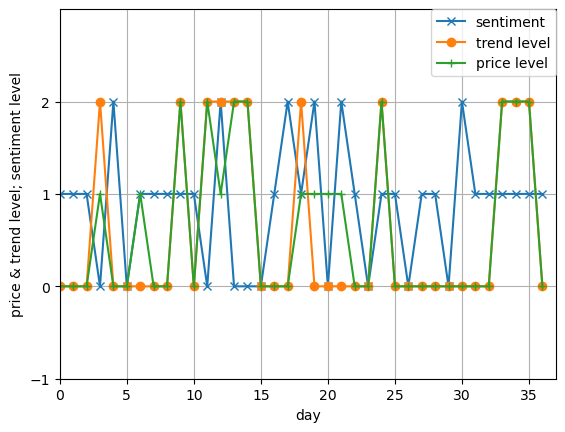

2023-03-01    14
2023-03-06    12
2023-02-28    10
2023-03-02     5
2023-03-08     5
2023-02-26     4
2023-03-07     3
2023-02-27     2
2023-03-09     1
2023-03-10     1
Name: date, dtype: int64


0it [00:00, ?it/s]

TWTR: No data found, symbol may be delisted


1it [00:01,  1.55s/it]

TWTR: No data found, symbol may be delisted


2it [00:02,  1.21s/it]

Got error from yahoo api for ticker FB, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}
- FB: No timezone found, symbol may be delisted


3it [00:03,  1.10s/it]

TWTR: No data found, symbol may be delisted


4it [00:03,  1.16it/s]

TWTR: No data found, symbol may be delisted


7it [00:06,  1.19it/s]

TWTR: No data found, symbol may be delisted


9it [00:06,  2.00it/s]

TWTR: No data found, symbol may be delisted


10it [00:06,  1.44it/s]

Forbes 2


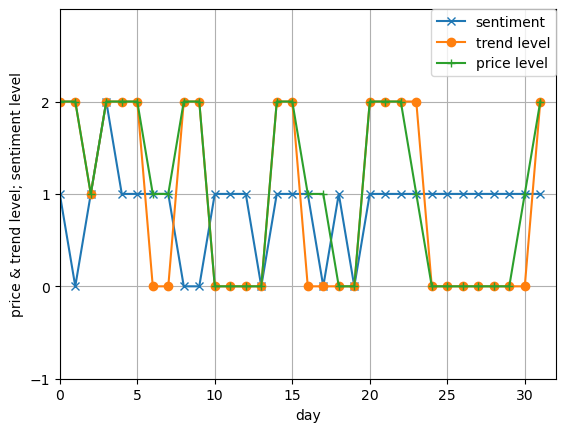

2023-03-01    11
2023-02-28     7
2023-03-08     7
2023-03-06     5
2023-03-09     5
2023-02-26     2
2023-02-27     2
2023-03-02     1
2023-03-07     1
2023-03-10     1
Name: date, dtype: int64


0it [00:00, ?it/s]

TWTR: No data found, symbol may be delisted
Got error from yahoo api for ticker FB, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}
- FB: No timezone found, symbol may be delisted


2it [00:02,  1.03it/s]

TWTR: No data found, symbol may be delisted


4it [00:03,  1.10it/s]

TWTR: No data found, symbol may be delisted


5it [00:05,  1.08s/it]

TWTR: No data found, symbol may be delisted


7it [00:06,  1.39it/s]

TWTR: No data found, symbol may be delisted


10it [00:06,  1.56it/s]


WSJ 2


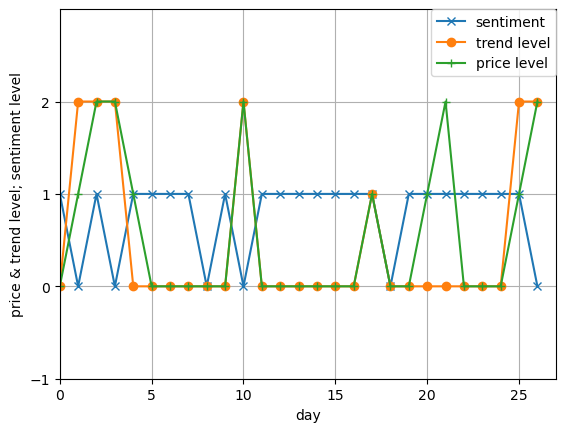

2023-03-01    8
2023-02-28    7
2023-03-08    7
2023-03-06    5
2023-02-26    3
2023-03-02    3
2023-02-27    2
2023-03-09    2
Name: date, dtype: int64


0it [00:00, ?it/s]

TWTR: No data found, symbol may be delisted


1it [00:00,  1.35it/s]

TWTR: No data found, symbol may be delisted


2it [00:01,  1.08it/s]

TWTR: No data found, symbol may be delisted


4it [00:02,  1.72it/s]

TWTR: No data found, symbol may be delisted


6it [00:02,  2.92it/s]

TWTR: No data found, symbol may be delisted


8it [00:03,  2.32it/s]

TechCrunch 2


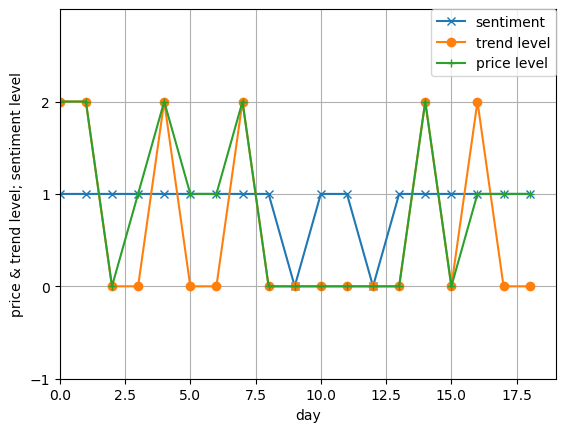

2023-03-01    14
2023-03-06     9
2023-02-28     6
2023-03-08     3
2023-03-02     2
2023-03-05     2
2023-02-26     1
Name: date, dtype: int64


0it [00:00, ?it/s]

Got error from yahoo api for ticker DISCA, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}
- DISCA: No timezone found, symbol may be delisted
Got error from yahoo api for ticker DISCK, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}
- DISCK: No timezone found, symbol may be delisted


4it [00:02,  1.95it/s]

TWTR: No data found, symbol may be delisted


7it [00:03,  2.16it/s]

GerberKawasaki 2


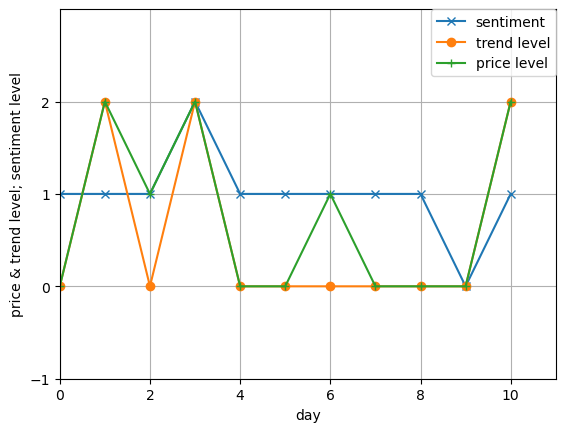

2023-03-01    8
2023-03-09    6
2023-02-28    5
2023-03-08    4
2023-03-06    3
2023-03-07    3
2023-03-10    2
2023-02-27    1
2023-03-13    1
Name: date, dtype: int64


9it [00:04,  2.01it/s]

TheStreet 2


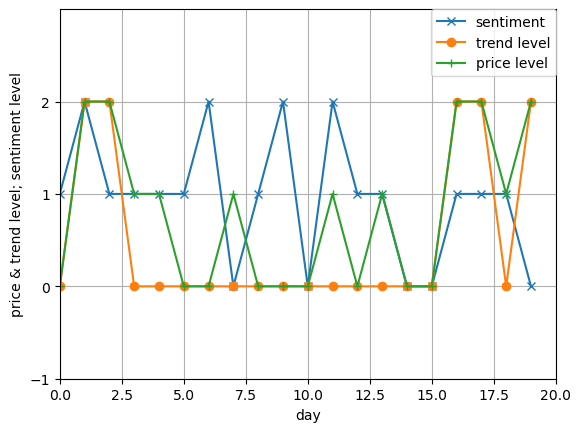

2023-03-09    4
2023-03-01    3
2023-02-27    2
2023-03-02    2
2023-03-06    2
2023-03-07    2
2023-02-28    2
2023-03-13    1
Name: date, dtype: int64


2it [00:01,  1.34it/s]

TWTR: No data found, symbol may be delisted


3it [00:01,  1.46it/s]

TWTR: No data found, symbol may be delisted


4it [00:02,  1.92it/s]

Got error from yahoo api for ticker FB, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}
- FB: No timezone found, symbol may be delisted


8it [00:04,  1.93it/s]


nytimes 2


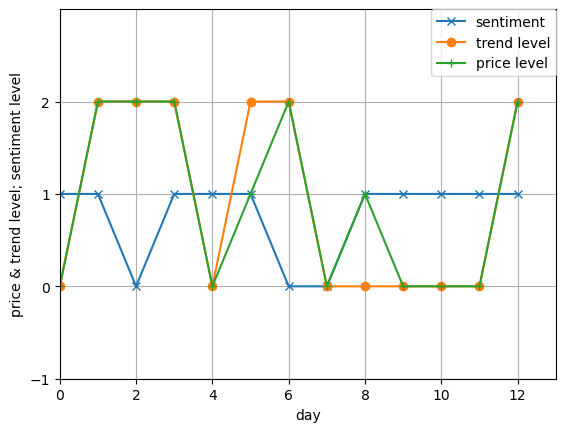

2023-03-01    4
2023-03-02    2
2023-03-06    2
2023-02-26    1
2023-02-28    1
2023-03-08    1
Name: date, dtype: int64


0it [00:00, ?it/s]

TWTR: No data found, symbol may be delisted


3it [00:01,  2.25it/s]

TWTR: No data found, symbol may be delisted


6it [00:02,  2.92it/s]

TWTR: No data found, symbol may be delisted
TheStalwart 2


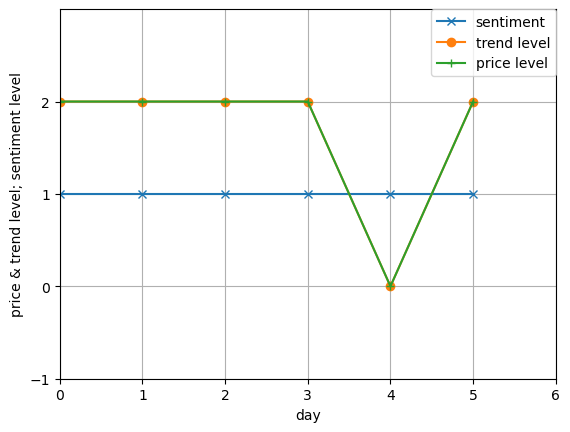

2023-02-28    2
2023-02-27    1
2023-03-01    1
2023-03-02    1
2023-03-06    1
2023-03-08    1
Name: date, dtype: int64


6it [00:01,  3.79it/s]


FT 2


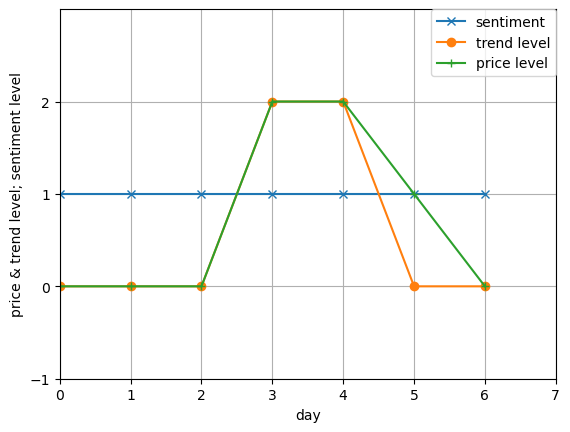

2023-03-01    2
2023-03-08    2
2023-03-09    2
2023-03-06    1
Name: date, dtype: int64


4it [00:01,  3.21it/s]

bespokeinvest 2


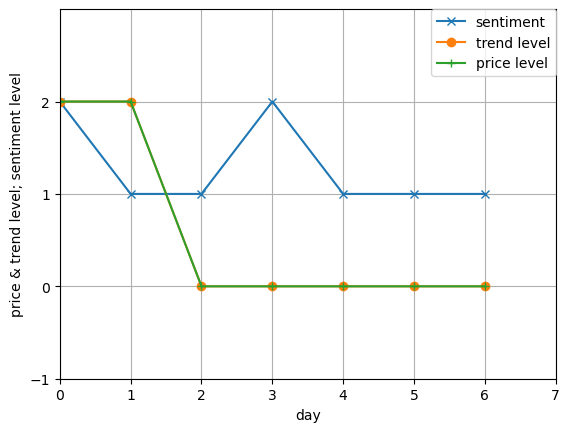

2023-03-01    2
2023-02-26    1
2023-03-06    1
2023-03-08    1
Name: date, dtype: int64


4it [00:01,  2.59it/s]

GGP: No data found for this date range, symbol may be delisted
TheEconomist 2


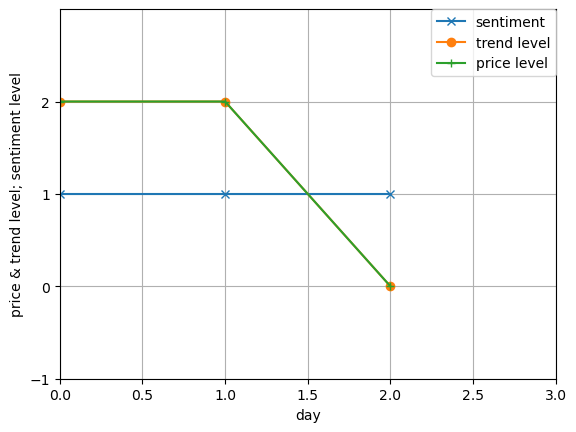

2023-03-01    42
2023-02-28    32
2023-03-06    25
2023-03-09    18
2023-03-07    12
2023-02-27    11
2023-03-08    11
2023-03-10    10
2023-03-02     8
2023-02-26     6
2023-03-13     3
Name: date, dtype: int64


2it [00:06,  2.96s/it]

TWTR: No data found, symbol may be delisted


4it [00:09,  2.22s/it]

Got error from yahoo api for ticker CERN, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}
- CERN: No timezone found, symbol may be delisted
TWTR: No data found, symbol may be delisted
Got error from yahoo api for ticker FB, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}
- FB: No timezone found, symbol may be delisted


8it [00:15,  1.60s/it]

Got error from yahoo api for ticker CERN, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}
- CERN: No timezone found, symbol may be delisted
Got error from yahoo api for ticker HRS, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}
- HRS: No timezone found, symbol may be delisted


10it [00:16,  1.12s/it]

TWTR: No data found, symbol may be delisted


11it [00:17,  1.60s/it]

Reuters 3


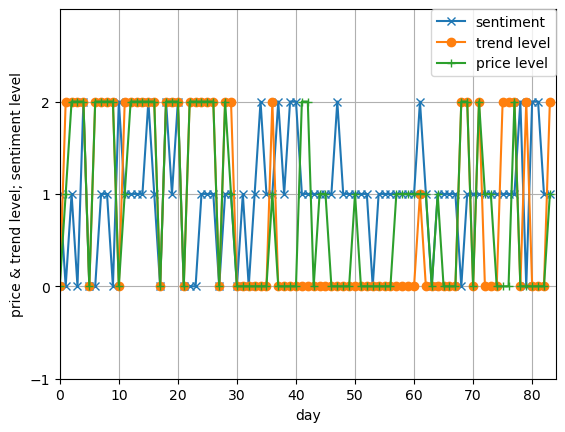

2023-03-01    29
2023-03-09    27
2023-02-28    20
2023-03-06    20
2023-03-08    11
2023-02-26    10
2023-03-02     6
2023-02-27     3
2023-03-07     3
2023-03-10     3
Name: date, dtype: int64


0it [00:00, ?it/s]

Got error from yahoo api for ticker FB, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}
- FB: No timezone found, symbol may be delisted
TWTR: No data found, symbol may be delisted


1it [00:02,  2.31s/it]

Got error from yahoo api for ticker DISCA, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}
- DISCA: No timezone found, symbol may be delisted
Got error from yahoo api for ticker DISCK, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}
- DISCK: No timezone found, symbol may be delisted
TWTR: No data found, symbol may be delisted


2it [00:04,  2.49s/it]

TWTR: No data found, symbol may be delisted


3it [00:07,  2.53s/it]

TWTR: No data found, symbol may be delisted


5it [00:10,  1.70s/it]

TWTR: No data found, symbol may be delisted


7it [00:11,  1.23s/it]

TWTR: No data found, symbol may be delisted


10it [00:13,  1.37s/it]

Got error from yahoo api for ticker HRS, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}
- HRS: No timezone found, symbol may be delisted
business 3


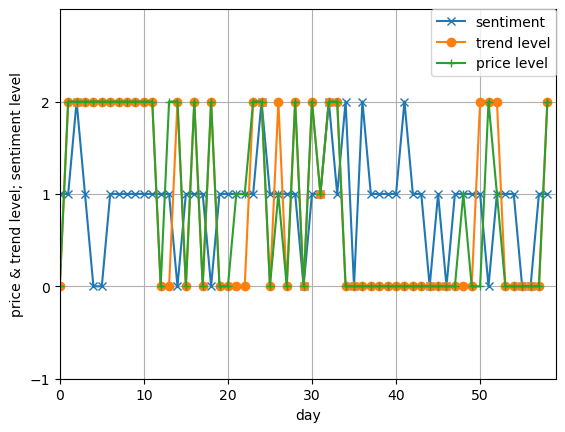

2023-02-28    18
2023-03-06    17
2023-03-08    17
2023-03-01    14
2023-02-26    11
2023-03-09     8
2023-03-07     3
2023-03-10     2
2023-02-27     1
2023-03-02     1
Name: date, dtype: int64


1it [00:02,  2.70s/it]

TWTR: No data found, symbol may be delisted


2it [00:04,  2.03s/it]

TWTR: No data found, symbol may be delisted


5it [00:07,  1.36s/it]

TWTR: No data found, symbol may be delisted
Got error from yahoo api for ticker DISCA, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}
- DISCA: No timezone found, symbol may be delisted
Got error from yahoo api for ticker DISCK, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}
- DISCK: No timezone found, symbol may be delisted


7it [00:09,  1.08it/s]

Got error from yahoo api for ticker FB, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}
- FB: No timezone found, symbol may be delisted


10it [00:10,  1.01s/it]


MarketWatch 3


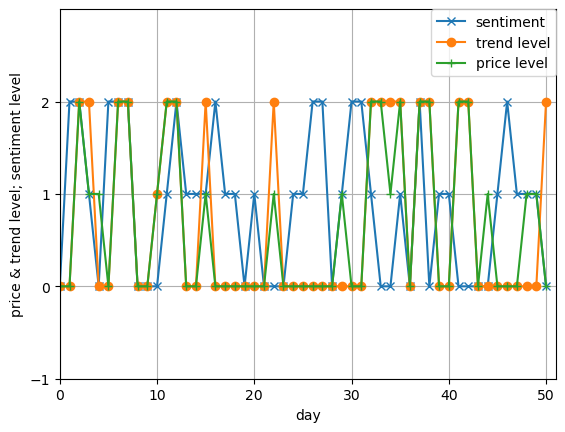

2023-02-28    18
2023-03-01    18
2023-03-06    13
2023-03-09    13
2023-03-08     5
2023-03-02     2
2023-03-07     2
2023-02-26     2
2023-03-13     2
2023-02-27     1
Name: date, dtype: int64


2it [00:02,  1.17s/it]

TWTR: No data found, symbol may be delisted


4it [00:05,  1.60s/it]

TWTR: No data found, symbol may be delisted


7it [00:06,  1.49it/s]

Got error from yahoo api for ticker FB, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}
- FB: No timezone found, symbol may be delisted
TWTR: No data found, symbol may be delisted


8it [00:07,  1.82it/s]

DDR: No data found for this date range, symbol may be delisted


10it [00:07,  1.31it/s]


YahooFinance 3


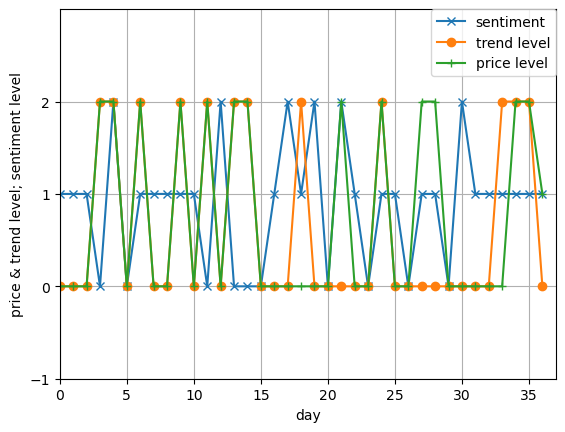

2023-03-01    14
2023-03-06    12
2023-02-28    10
2023-03-02     5
2023-03-08     5
2023-02-26     4
2023-03-07     3
2023-02-27     2
2023-03-09     1
2023-03-10     1
Name: date, dtype: int64


0it [00:00, ?it/s]

TWTR: No data found, symbol may be delisted


1it [00:01,  1.69s/it]

TWTR: No data found, symbol may be delisted


2it [00:02,  1.13s/it]

Got error from yahoo api for ticker FB, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}
- FB: No timezone found, symbol may be delisted


3it [00:03,  1.06s/it]

TWTR: No data found, symbol may be delisted


4it [00:04,  1.12it/s]

TWTR: No data found, symbol may be delisted


7it [00:06,  1.07it/s]

TWTR: No data found, symbol may be delisted


9it [00:07,  1.63it/s]

TWTR: No data found, symbol may be delisted


10it [00:07,  1.28it/s]


Forbes 3


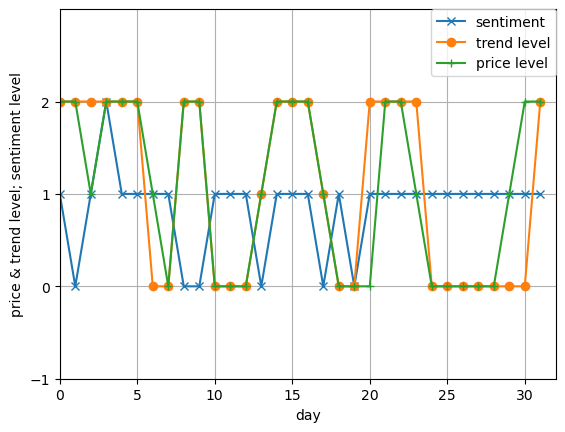

2023-03-01    11
2023-02-28     7
2023-03-08     7
2023-03-06     5
2023-03-09     5
2023-02-26     2
2023-02-27     2
2023-03-02     1
2023-03-07     1
2023-03-10     1
Name: date, dtype: int64


0it [00:00, ?it/s]

TWTR: No data found, symbol may be delisted


1it [00:00,  1.15it/s]

Got error from yahoo api for ticker FB, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}
- FB: No timezone found, symbol may be delisted


2it [00:02,  1.16s/it]

TWTR: No data found, symbol may be delisted


4it [00:04,  1.12s/it]

TWTR: No data found, symbol may be delisted


5it [00:05,  1.02it/s]

TWTR: No data found, symbol may be delisted


7it [00:06,  1.41it/s]

TWTR: No data found, symbol may be delisted


10it [00:06,  1.49it/s]

WSJ 3


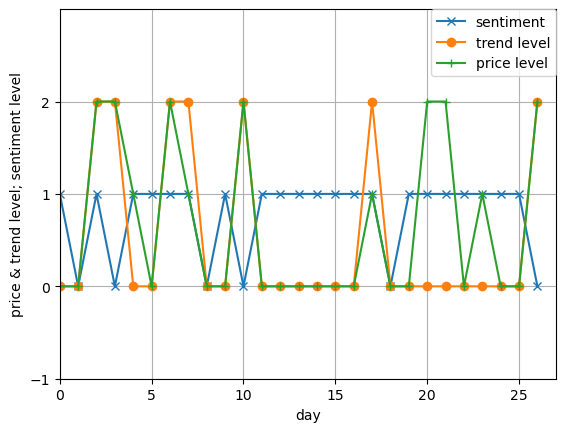

2023-03-01    8
2023-02-28    7
2023-03-08    7
2023-03-06    5
2023-02-26    3
2023-03-02    3
2023-02-27    2
2023-03-09    2
Name: date, dtype: int64


0it [00:00, ?it/s]

TWTR: No data found, symbol may be delisted


1it [00:01,  1.36s/it]

TWTR: No data found, symbol may be delisted


2it [00:01,  1.12it/s]

TWTR: No data found, symbol may be delisted


4it [00:03,  1.49it/s]

TWTR: No data found, symbol may be delisted


6it [00:03,  2.68it/s]

TWTR: No data found, symbol may be delisted


8it [00:04,  1.78it/s]

TechCrunch 3


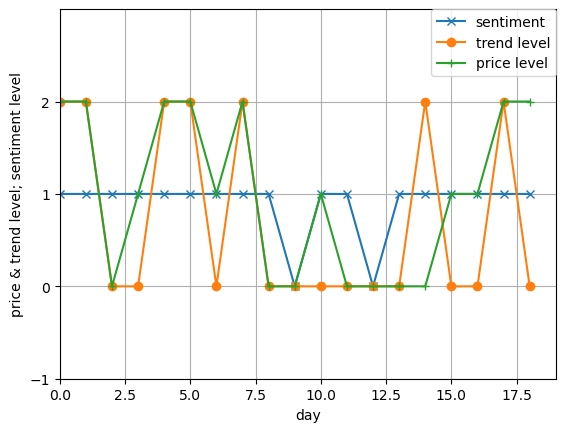

2023-03-01    14
2023-03-06     9
2023-02-28     6
2023-03-08     3
2023-03-02     2
2023-03-05     2
2023-02-26     1
Name: date, dtype: int64


0it [00:00, ?it/s]

Got error from yahoo api for ticker DISCA, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}
- DISCA: No timezone found, symbol may be delisted
Got error from yahoo api for ticker DISCK, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}
- DISCK: No timezone found, symbol may be delisted


4it [00:02,  1.62it/s]

TWTR: No data found, symbol may be delisted


7it [00:02,  2.50it/s]

GerberKawasaki 3


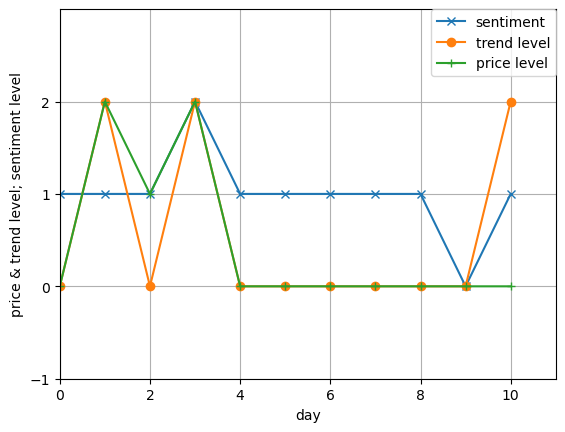

2023-03-01    8
2023-03-09    6
2023-02-28    5
2023-03-08    4
2023-03-06    3
2023-03-07    3
2023-03-10    2
2023-02-27    1
2023-03-13    1
Name: date, dtype: int64


9it [00:03,  2.91it/s]

TheStreet 3


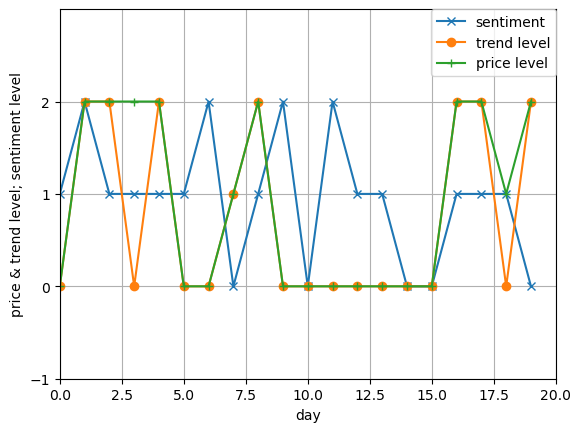

2023-03-09    4
2023-03-01    3
2023-02-27    2
2023-03-02    2
2023-03-06    2
2023-03-07    2
2023-02-28    2
2023-03-13    1
Name: date, dtype: int64


2it [00:00,  2.01it/s]

TWTR: No data found, symbol may be delisted


3it [00:01,  1.92it/s]

TWTR: No data found, symbol may be delisted


5it [00:02,  2.76it/s]

Got error from yahoo api for ticker FB, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}
- FB: No timezone found, symbol may be delisted


8it [00:02,  2.73it/s]


nytimes 3


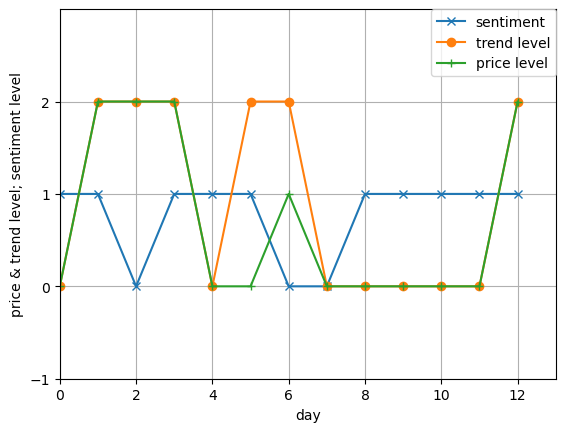

2023-03-01    4
2023-03-02    2
2023-03-06    2
2023-02-26    1
2023-02-28    1
2023-03-08    1
Name: date, dtype: int64


0it [00:00, ?it/s]

TWTR: No data found, symbol may be delisted


3it [00:01,  1.57it/s]

TWTR: No data found, symbol may be delisted


6it [00:02,  2.42it/s]


TWTR: No data found, symbol may be delisted
TheStalwart 3


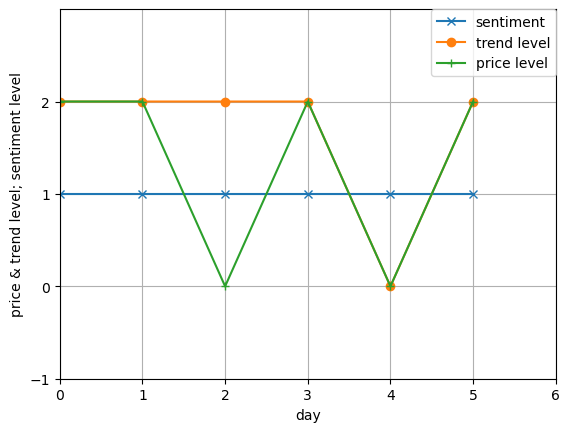

2023-02-28    2
2023-02-27    1
2023-03-01    1
2023-03-02    1
2023-03-06    1
2023-03-08    1
Name: date, dtype: int64


6it [00:00,  6.37it/s]

FT 3


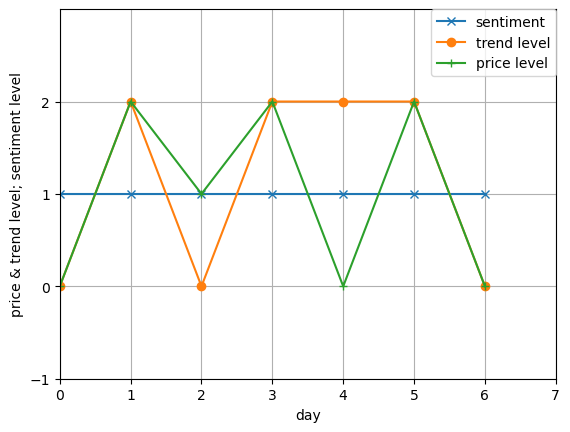

2023-03-01    2
2023-03-08    2
2023-03-09    2
2023-03-06    1
Name: date, dtype: int64


4it [00:01,  3.29it/s]

bespokeinvest 3


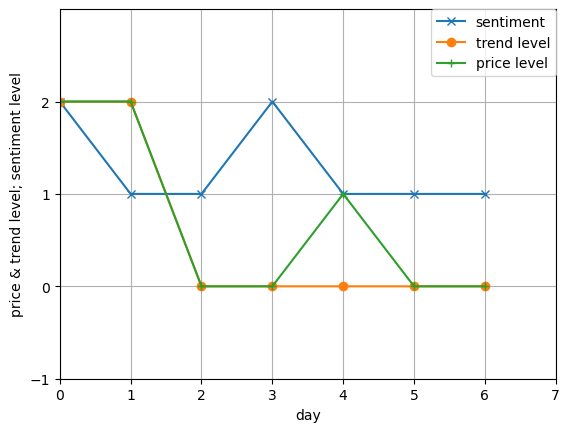

2023-03-01    2
2023-02-26    1
2023-03-06    1
2023-03-08    1
Name: date, dtype: int64


3it [00:00,  6.43it/s]

GGP: No data found for this date range, symbol may be delisted


4it [00:00,  4.41it/s]

TheEconomist 3


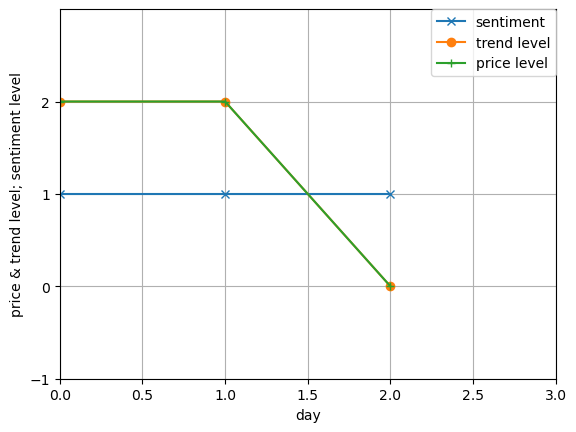

2023-03-01    42
2023-02-28    32
2023-03-06    25
2023-03-09    18
2023-03-07    12
2023-02-27    11
2023-03-08    11
2023-03-10    10
2023-03-02     8
2023-02-26     6
2023-03-13     3
Name: date, dtype: int64


2it [00:04,  2.36s/it]

TWTR: No data found, symbol may be delisted


4it [00:09,  2.23s/it]

Got error from yahoo api for ticker CERN, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}
- CERN: No timezone found, symbol may be delisted
TWTR: No data found, symbol may be delisted
Got error from yahoo api for ticker FB, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}
- FB: No timezone found, symbol may be delisted


8it [00:13,  1.31s/it]

Got error from yahoo api for ticker CERN, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}
- CERN: No timezone found, symbol may be delisted
Got error from yahoo api for ticker HRS, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}
- HRS: No timezone found, symbol may be delisted


10it [00:15,  1.05s/it]

TWTR: No data found, symbol may be delisted


11it [00:16,  1.50s/it]

Reuters 4


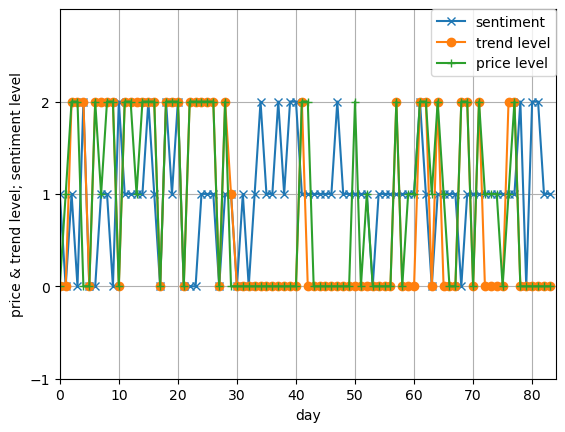

2023-03-01    29
2023-03-09    27
2023-02-28    20
2023-03-06    20
2023-03-08    11
2023-02-26    10
2023-03-02     6
2023-02-27     3
2023-03-07     3
2023-03-10     3
Name: date, dtype: int64


0it [00:00, ?it/s]

Got error from yahoo api for ticker FB, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}
- FB: No timezone found, symbol may be delisted
TWTR: No data found, symbol may be delisted


1it [00:02,  2.80s/it]

Got error from yahoo api for ticker DISCA, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}
- DISCA: No timezone found, symbol may be delisted
Got error from yahoo api for ticker DISCK, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}
- DISCK: No timezone found, symbol may be delisted
TWTR: No data found, symbol may be delisted


2it [00:05,  2.75s/it]

TWTR: No data found, symbol may be delisted


3it [00:08,  2.82s/it]

TWTR: No data found, symbol may be delisted


5it [00:10,  1.74s/it]

TWTR: No data found, symbol may be delisted


7it [00:12,  1.16s/it]

TWTR: No data found, symbol may be delisted


10it [00:13,  1.32s/it]

Got error from yahoo api for ticker HRS, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}
- HRS: No timezone found, symbol may be delisted
business 4


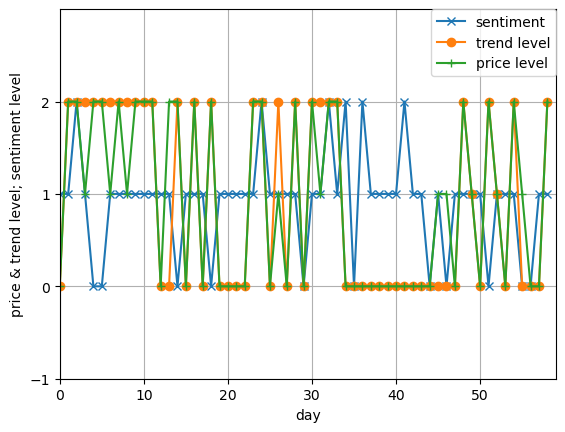

2023-02-28    18
2023-03-06    17
2023-03-08    17
2023-03-01    14
2023-02-26    11
2023-03-09     8
2023-03-07     3
2023-03-10     2
2023-02-27     1
2023-03-02     1
Name: date, dtype: int64


1it [00:01,  1.93s/it]

TWTR: No data found, symbol may be delisted


2it [00:03,  1.76s/it]

TWTR: No data found, symbol may be delisted


5it [00:07,  1.30s/it]

TWTR: No data found, symbol may be delisted
Got error from yahoo api for ticker DISCA, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}
- DISCA: No timezone found, symbol may be delisted
Got error from yahoo api for ticker DISCK, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}
- DISCK: No timezone found, symbol may be delisted


8it [00:08,  1.59it/s]

Got error from yahoo api for ticker FB, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}
- FB: No timezone found, symbol may be delisted


10it [00:08,  1.12it/s]


MarketWatch 4


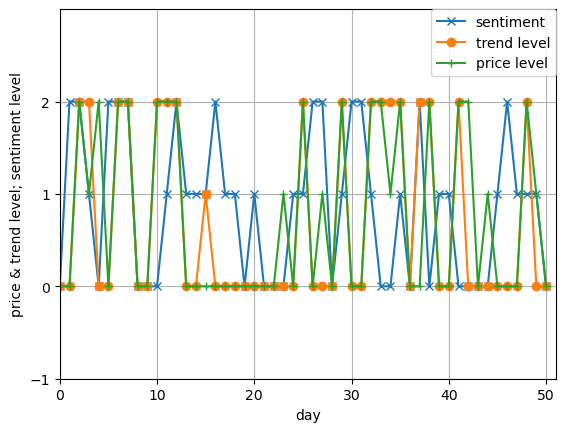

2023-02-28    18
2023-03-01    18
2023-03-06    13
2023-03-09    13
2023-03-08     5
2023-03-02     2
2023-03-07     2
2023-02-26     2
2023-03-13     2
2023-02-27     1
Name: date, dtype: int64


2it [00:02,  1.13s/it]

TWTR: No data found, symbol may be delisted


4it [00:05,  1.32s/it]

TWTR: No data found, symbol may be delisted


7it [00:06,  1.40it/s]

Got error from yahoo api for ticker FB, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}
- FB: No timezone found, symbol may be delisted
TWTR: No data found, symbol may be delisted


8it [00:07,  1.45it/s]

DDR: No data found for this date range, symbol may be delisted


10it [00:07,  1.28it/s]


YahooFinance 4


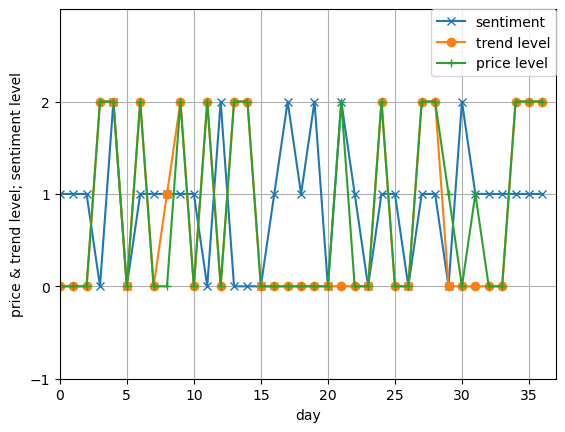

2023-03-01    14
2023-03-06    12
2023-02-28    10
2023-03-02     5
2023-03-08     5
2023-02-26     4
2023-03-07     3
2023-02-27     2
2023-03-09     1
2023-03-10     1
Name: date, dtype: int64


0it [00:00, ?it/s]

TWTR: No data found, symbol may be delisted


1it [00:01,  1.69s/it]

TWTR: No data found, symbol may be delisted


2it [00:02,  1.17s/it]

Got error from yahoo api for ticker FB, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}
- FB: No timezone found, symbol may be delisted


3it [00:03,  1.27s/it]

TWTR: No data found, symbol may be delisted


4it [00:04,  1.09it/s]

TWTR: No data found, symbol may be delisted


7it [00:05,  1.59it/s]

TWTR: No data found, symbol may be delisted


9it [00:06,  2.54it/s]

TWTR: No data found, symbol may be delisted


10it [00:06,  1.54it/s]

Forbes 4


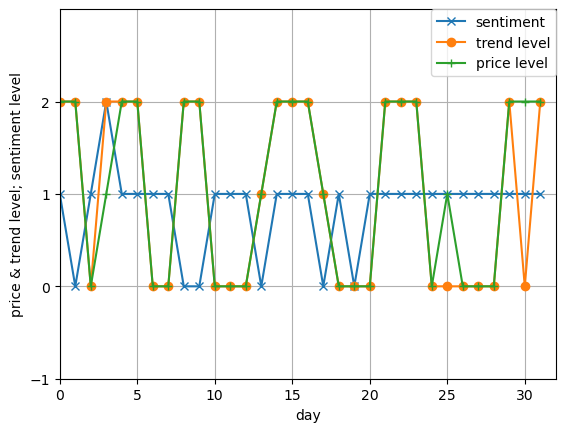

2023-03-01    11
2023-02-28     7
2023-03-08     7
2023-03-06     5
2023-03-09     5
2023-02-26     2
2023-02-27     2
2023-03-02     1
2023-03-07     1
2023-03-10     1
Name: date, dtype: int64


0it [00:00, ?it/s]

TWTR: No data found, symbol may be delisted


1it [00:00,  1.12it/s]

Got error from yahoo api for ticker FB, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}
- FB: No timezone found, symbol may be delisted


2it [00:01,  1.06it/s]

TWTR: No data found, symbol may be delisted


4it [00:03,  1.16it/s]

TWTR: No data found, symbol may be delisted


5it [00:04,  1.26it/s]

TWTR: No data found, symbol may be delisted


7it [00:04,  1.96it/s]

TWTR: No data found, symbol may be delisted


10it [00:05,  1.75it/s]

WSJ 4


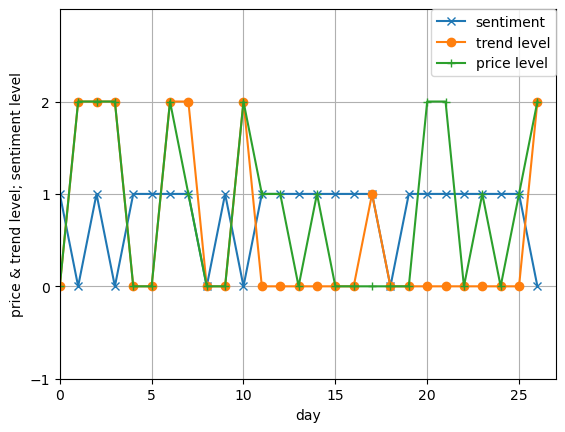

2023-03-01    8
2023-02-28    7
2023-03-08    7
2023-03-06    5
2023-02-26    3
2023-03-02    3
2023-02-27    2
2023-03-09    2
Name: date, dtype: int64


0it [00:00, ?it/s]

TWTR: No data found, symbol may be delisted


1it [00:01,  1.58s/it]

TWTR: No data found, symbol may be delisted


2it [00:02,  1.25s/it]

TWTR: No data found, symbol may be delisted


4it [00:04,  1.01it/s]

TWTR: No data found, symbol may be delisted


6it [00:04,  1.94it/s]

TWTR: No data found, symbol may be delisted


8it [00:05,  1.46it/s]

TechCrunch 4


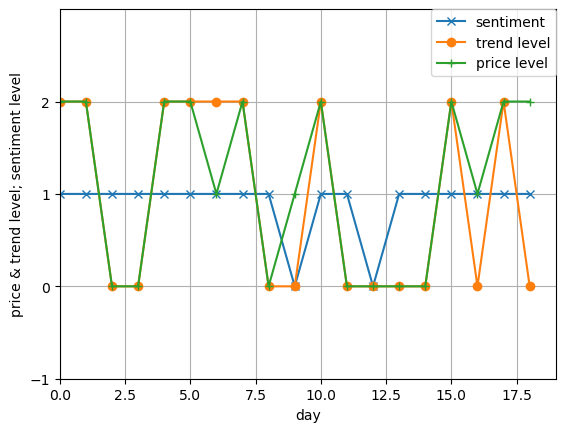

2023-03-01    14
2023-03-06     9
2023-02-28     6
2023-03-08     3
2023-03-02     2
2023-03-05     2
2023-02-26     1
Name: date, dtype: int64


0it [00:00, ?it/s]

Got error from yahoo api for ticker DISCA, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}
- DISCA: No timezone found, symbol may be delisted
Got error from yahoo api for ticker DISCK, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}
- DISCK: No timezone found, symbol may be delisted


4it [00:01,  2.89it/s]

TWTR: No data found, symbol may be delisted


7it [00:01,  3.58it/s]

GerberKawasaki 4


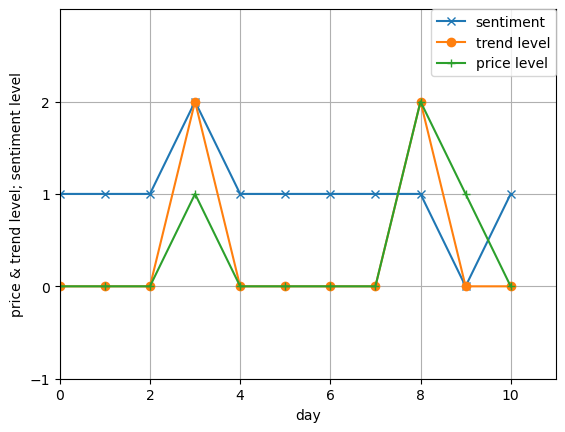

2023-03-01    8
2023-03-09    6
2023-02-28    5
2023-03-08    4
2023-03-06    3
2023-03-07    3
2023-03-10    2
2023-02-27    1
2023-03-13    1
Name: date, dtype: int64


9it [00:02,  3.14it/s]

TheStreet 4


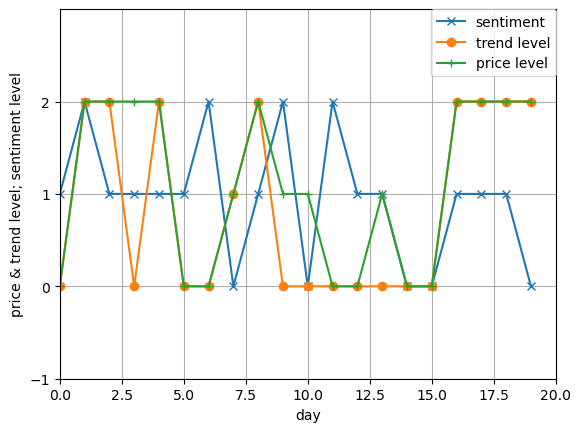

2023-03-09    4
2023-03-01    3
2023-02-27    2
2023-03-02    2
2023-03-06    2
2023-03-07    2
2023-02-28    2
2023-03-13    1
Name: date, dtype: int64


1it [00:00,  3.22it/s]

TWTR: No data found, symbol may be delisted


3it [00:01,  1.91it/s]

TWTR: No data found, symbol may be delisted


5it [00:02,  2.58it/s]

Got error from yahoo api for ticker FB, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}
- FB: No timezone found, symbol may be delisted


8it [00:03,  2.66it/s]


nytimes 4


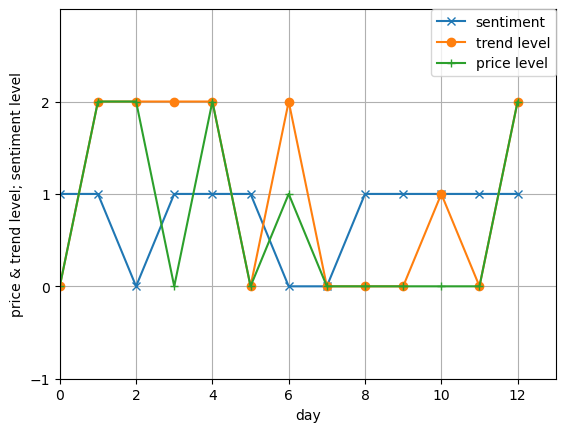

2023-03-01    4
2023-03-02    2
2023-03-06    2
2023-02-26    1
2023-02-28    1
2023-03-08    1
Name: date, dtype: int64


0it [00:00, ?it/s]

TWTR: No data found, symbol may be delisted


4it [00:01,  4.16it/s]

TWTR: No data found, symbol may be delisted


6it [00:01,  4.15it/s]

TWTR: No data found, symbol may be delisted
TheStalwart 4


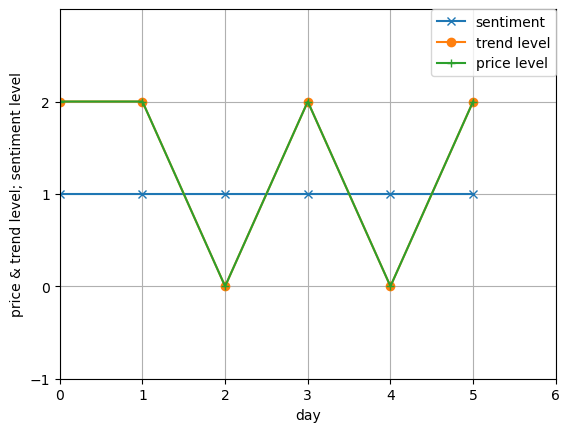

2023-02-28    2
2023-02-27    1
2023-03-01    1
2023-03-02    1
2023-03-06    1
2023-03-08    1
Name: date, dtype: int64


6it [00:00,  6.25it/s]

FT 4


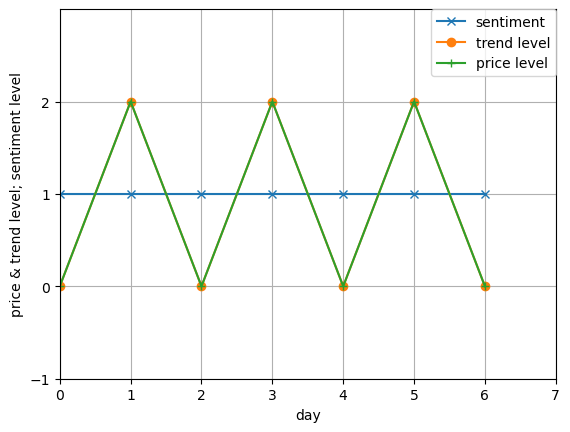

2023-03-01    2
2023-03-08    2
2023-03-09    2
2023-03-06    1
Name: date, dtype: int64


4it [00:01,  3.51it/s]

bespokeinvest 4


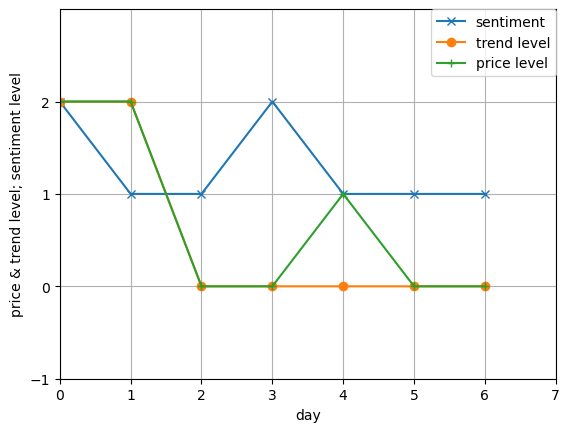

2023-03-01    2
2023-02-26    1
2023-03-06    1
2023-03-08    1
Name: date, dtype: int64


4it [00:00,  6.76it/s]

GGP: No data found for this date range, symbol may be delisted
TheEconomist 4


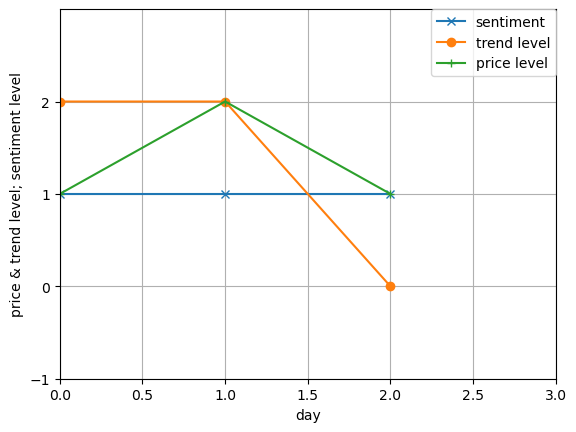

2023-03-01    42
2023-02-28    32
2023-03-06    25
2023-03-09    18
2023-03-07    12
2023-02-27    11
2023-03-08    11
2023-03-10    10
2023-03-02     8
2023-02-26     6
2023-03-13     3
Name: date, dtype: int64


2it [00:04,  2.22s/it]

TWTR: No data found, symbol may be delisted


4it [00:08,  1.99s/it]

Got error from yahoo api for ticker CERN, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}
- CERN: No timezone found, symbol may be delisted
TWTR: No data found, symbol may be delisted
Got error from yahoo api for ticker FB, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}
- FB: No timezone found, symbol may be delisted


8it [00:13,  1.36s/it]

Got error from yahoo api for ticker CERN, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}
- CERN: No timezone found, symbol may be delisted
Got error from yahoo api for ticker HRS, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}
- HRS: No timezone found, symbol may be delisted


10it [00:15,  1.07s/it]

TWTR: No data found, symbol may be delisted


11it [00:15,  1.41s/it]

Reuters 5


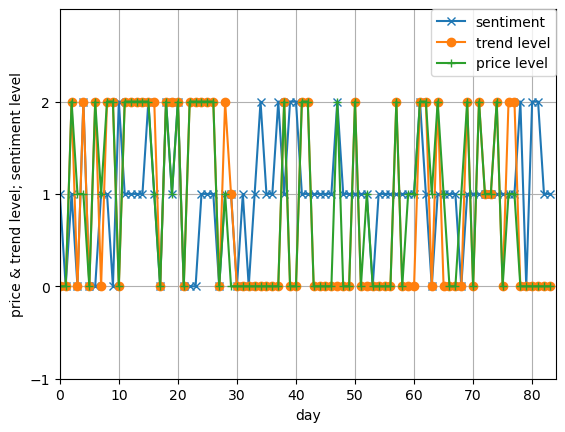

2023-03-01    29
2023-03-09    27
2023-02-28    20
2023-03-06    20
2023-03-08    11
2023-02-26    10
2023-03-02     6
2023-02-27     3
2023-03-07     3
2023-03-10     3
Name: date, dtype: int64


0it [00:00, ?it/s]

Got error from yahoo api for ticker FB, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}
- FB: No timezone found, symbol may be delisted
TWTR: No data found, symbol may be delisted


1it [00:01,  1.82s/it]

Got error from yahoo api for ticker DISCA, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}
- DISCA: No timezone found, symbol may be delisted
Got error from yahoo api for ticker DISCK, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}
- DISCK: No timezone found, symbol may be delisted
TWTR: No data found, symbol may be delisted


2it [00:04,  2.30s/it]

TWTR: No data found, symbol may be delisted


3it [00:06,  2.12s/it]

TWTR: No data found, symbol may be delisted


5it [00:08,  1.55s/it]

TWTR: No data found, symbol may be delisted


7it [00:10,  1.13s/it]

TWTR: No data found, symbol may be delisted


10it [00:12,  1.21s/it]

Got error from yahoo api for ticker HRS, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}
- HRS: No timezone found, symbol may be delisted
business 5


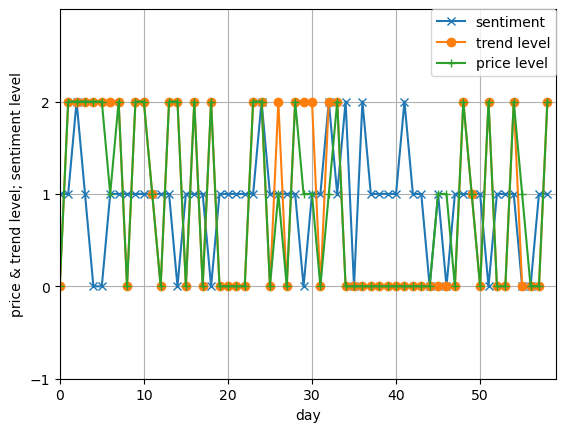

2023-02-28    18
2023-03-06    17
2023-03-08    17
2023-03-01    14
2023-02-26    11
2023-03-09     8
2023-03-07     3
2023-03-10     2
2023-02-27     1
2023-03-02     1
Name: date, dtype: int64


1it [00:02,  2.83s/it]

TWTR: No data found, symbol may be delisted


2it [00:05,  2.62s/it]

TWTR: No data found, symbol may be delisted


4it [00:08,  1.88s/it]

TWTR: No data found, symbol may be delisted


5it [00:09,  1.78s/it]

Got error from yahoo api for ticker DISCA, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}
- DISCA: No timezone found, symbol may be delisted
Got error from yahoo api for ticker DISCK, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}
- DISCK: No timezone found, symbol may be delisted


8it [00:11,  1.22it/s]

Got error from yahoo api for ticker FB, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}
- FB: No timezone found, symbol may be delisted


10it [00:11,  1.16s/it]


MarketWatch 5


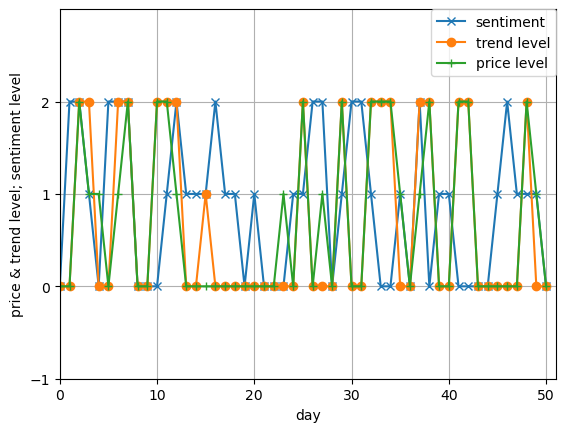

2023-02-28    18
2023-03-01    18
2023-03-06    13
2023-03-09    13
2023-03-08     5
2023-03-02     2
2023-03-07     2
2023-02-26     2
2023-03-13     2
2023-02-27     1
Name: date, dtype: int64


2it [00:02,  1.35s/it]

TWTR: No data found, symbol may be delisted


4it [00:05,  1.30s/it]

TWTR: No data found, symbol may be delisted


7it [00:06,  1.69it/s]

Got error from yahoo api for ticker FB, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}
- FB: No timezone found, symbol may be delisted
TWTR: No data found, symbol may be delisted
DDR: No data found for this date range, symbol may be delisted


10it [00:07,  1.43it/s]


YahooFinance 5


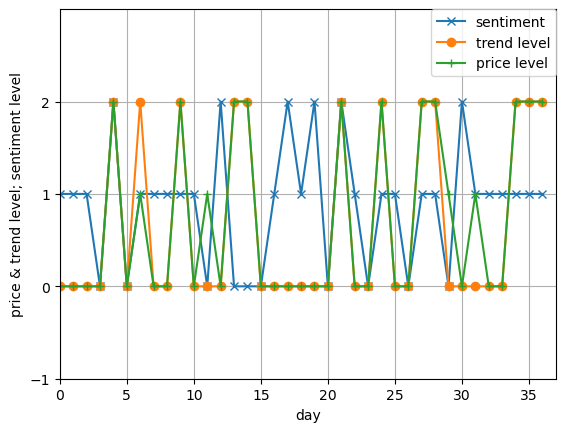

2023-03-01    14
2023-03-06    12
2023-02-28    10
2023-03-02     5
2023-03-08     5
2023-02-26     4
2023-03-07     3
2023-02-27     2
2023-03-09     1
2023-03-10     1
Name: date, dtype: int64


0it [00:00, ?it/s]

TWTR: No data found, symbol may be delisted


1it [00:01,  1.36s/it]

TWTR: No data found, symbol may be delisted


2it [00:01,  1.07it/s]

Got error from yahoo api for ticker FB, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}
- FB: No timezone found, symbol may be delisted


3it [00:02,  1.08it/s]

TWTR: No data found, symbol may be delisted


4it [00:03,  1.20it/s]

TWTR: No data found, symbol may be delisted


8it [00:05,  2.08it/s]

TWTR: No data found, symbol may be delisted
TWTR: No data found, symbol may be delisted


10it [00:05,  1.74it/s]

Forbes 5


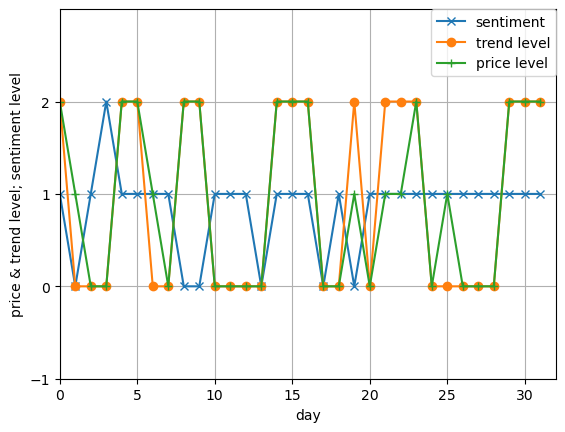

2023-03-01    11
2023-02-28     7
2023-03-08     7
2023-03-06     5
2023-03-09     5
2023-02-26     2
2023-02-27     2
2023-03-02     1
2023-03-07     1
2023-03-10     1
Name: date, dtype: int64


0it [00:00, ?it/s]

TWTR: No data found, symbol may be delisted


1it [00:01,  1.22s/it]

Got error from yahoo api for ticker FB, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}
- FB: No timezone found, symbol may be delisted


2it [00:02,  1.48s/it]

TWTR: No data found, symbol may be delisted


3it [00:03,  1.12s/it]

TWTR: No data found, symbol may be delisted


5it [00:05,  1.07it/s]

TWTR: No data found, symbol may be delisted


6it [00:05,  1.37it/s]

TWTR: No data found, symbol may be delisted


10it [00:06,  1.59it/s]

WSJ 5


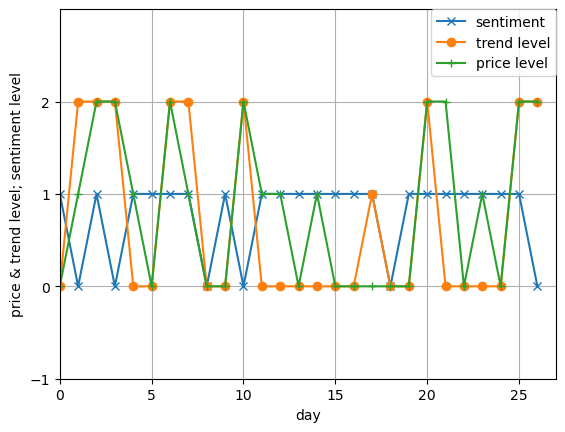

2023-03-01    8
2023-02-28    7
2023-03-08    7
2023-03-06    5
2023-02-26    3
2023-03-02    3
2023-02-27    2
2023-03-09    2
Name: date, dtype: int64


0it [00:00, ?it/s]

TWTR: No data found, symbol may be delisted


1it [00:00,  1.47it/s]

TWTR: No data found, symbol may be delisted


2it [00:01,  1.36it/s]

TWTR: No data found, symbol may be delisted


4it [00:02,  1.39it/s]

TWTR: No data found, symbol may be delisted


6it [00:03,  2.50it/s]

TWTR: No data found, symbol may be delisted


8it [00:04,  1.91it/s]

TechCrunch 5


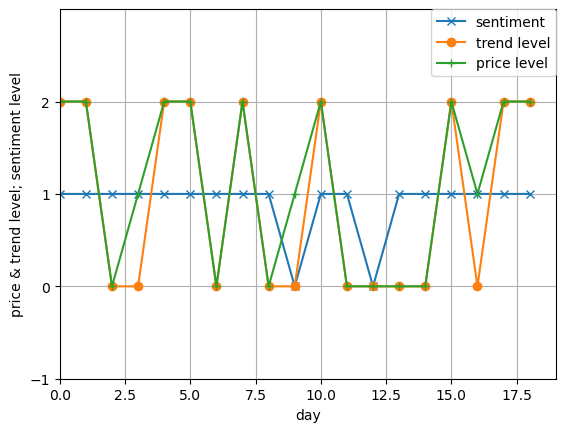

2023-03-01    14
2023-03-06     9
2023-02-28     6
2023-03-08     3
2023-03-02     2
2023-03-05     2
2023-02-26     1
Name: date, dtype: int64


0it [00:00, ?it/s]

Got error from yahoo api for ticker DISCA, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}
- DISCA: No timezone found, symbol may be delisted
Got error from yahoo api for ticker DISCK, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}
- DISCK: No timezone found, symbol may be delisted


5it [00:02,  3.21it/s]

TWTR: No data found, symbol may be delisted


7it [00:02,  3.09it/s]

GerberKawasaki 5


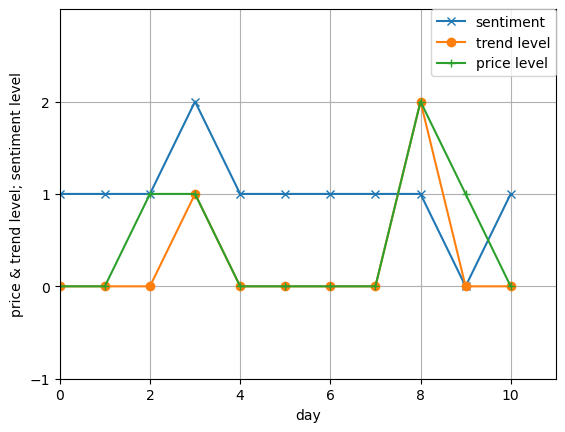

2023-03-01    8
2023-03-09    6
2023-02-28    5
2023-03-08    4
2023-03-06    3
2023-03-07    3
2023-03-10    2
2023-02-27    1
2023-03-13    1
Name: date, dtype: int64


9it [00:04,  2.22it/s]


TheStreet 5


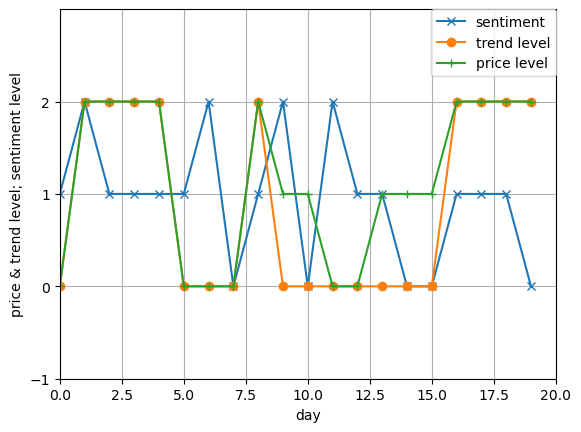

2023-03-09    4
2023-03-01    3
2023-02-27    2
2023-03-02    2
2023-03-06    2
2023-03-07    2
2023-02-28    2
2023-03-13    1
Name: date, dtype: int64


2it [00:01,  1.51it/s]

TWTR: No data found, symbol may be delisted


3it [00:01,  2.07it/s]

TWTR: No data found, symbol may be delisted


5it [00:02,  2.40it/s]

Got error from yahoo api for ticker FB, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}
- FB: No timezone found, symbol may be delisted


8it [00:03,  2.28it/s]


nytimes 5


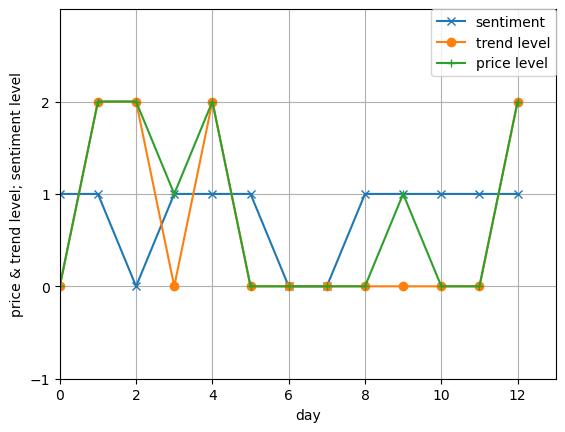

2023-03-01    4
2023-03-02    2
2023-03-06    2
2023-02-26    1
2023-02-28    1
2023-03-08    1
Name: date, dtype: int64


0it [00:00, ?it/s]

TWTR: No data found, symbol may be delisted


4it [00:01,  3.71it/s]

TWTR: No data found, symbol may be delisted


6it [00:01,  3.46it/s]


TWTR: No data found, symbol may be delisted
TheStalwart 5


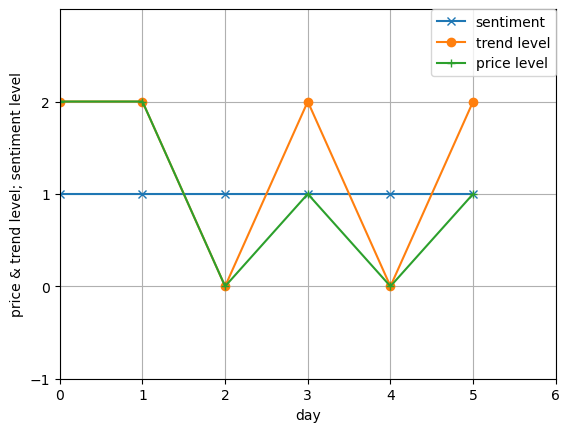

2023-02-28    2
2023-02-27    1
2023-03-01    1
2023-03-02    1
2023-03-06    1
2023-03-08    1
Name: date, dtype: int64


6it [00:01,  3.32it/s]


FT 5


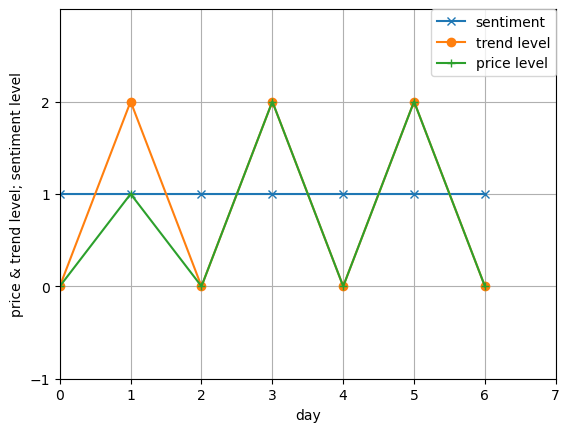

2023-03-01    2
2023-03-08    2
2023-03-09    2
2023-03-06    1
Name: date, dtype: int64


4it [00:01,  2.66it/s]

bespokeinvest 5


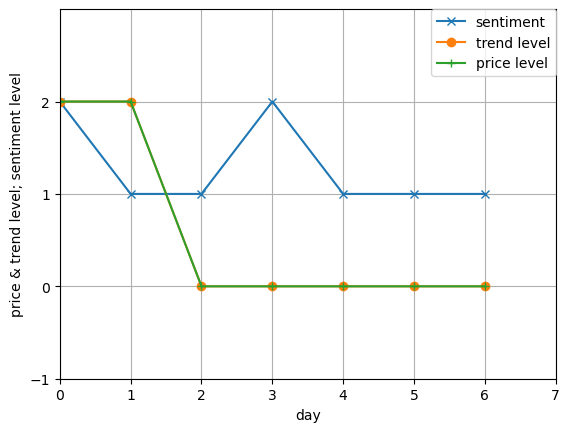

2023-03-01    2
2023-02-26    1
2023-03-06    1
2023-03-08    1
Name: date, dtype: int64


4it [00:00,  5.60it/s]

GGP: No data found for this date range, symbol may be delisted
TheEconomist 5


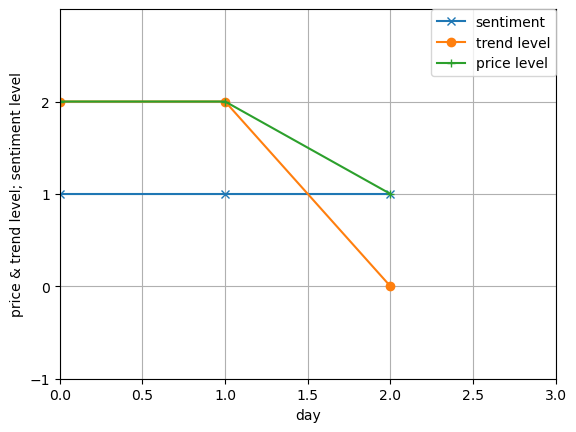

In [326]:
tweet_eval_df =  pd.DataFrame(columns = ['author', 'time_window', 
                                 'acc_trend','acc_price',
                                 'p_0_trend','p_1_trend','p_2_trend',
                                 'p_0_price','p_1_price','p_2_price'])
tweet_authors = tweets_df['source'].value_counts()
for i in range(1,6):
    for aut, cnt_aut in tweet_authors.iteritems():
        if cnt_aut >=5:
            acc_trend, acc_price ,trend_arr, price_arr, sen_arr = evaluate_tweet(aut,i,0.02,0.01)
            tweet_eval_df = tweet_eval_df.append({'author':aut,'time_window':i,
                                      'acc_trend':acc_trend,'acc_price':acc_price,
                                      'p_0_trend':con_prob(0,trend_arr,sen_arr),'p_1_trend':con_prob(1,trend_arr,sen_arr),'p_2_trend':con_prob(2,trend_arr,sen_arr),
                                      'p_0_price':con_prob(0,price_arr,sen_arr),'p_1_price':con_prob(1,price_arr,sen_arr),'p_2_price':con_prob(2,price_arr,sen_arr)
                                     }, ignore_index = True)
            print(aut, i)
            plot(sen_arr,trend_arr, price_arr)

In [328]:
tweet_eval_df.to_csv('../data/tweet_eval.csv',index=False)

In [366]:
sa_acc={}
sa_acc = sa_acc.fromkeys(authors.keys(),[0,0])
for aut, cnt_aut in authors.iteritems():
    trend_acc=sa_eval_df[sa_eval_df['author']==aut]['acc_trend'].mean()
    price_acc = sa_eval_df[sa_eval_df['author']==aut]['acc_price'].mean()
    sa_acc[aut] = [trend_acc,price_acc]

sa_acc = sorted(sa_acc.items(), key=lambda x:x[1][0],reverse=True)
sa_acc

[('Taylor Dart', [0.45600000000000007, 0.4]),
 ('Gen Alpha', [0.4, 0.28888888888888886]),
 ('Stephen Simpson', [0.3777777777777778, 0.28888888888888886]),
 ('Daniel Jones', [0.35, 0.26666666666666666]),
 ('Hoya Capital', [0.33333333333333337, 0.25]),
 ('Nick Ackerman', [0.3, 0.22857142857142856]),
 ('Trapping Value', [0.28695652173913044, 0.2347826086956522])]

In [376]:
tweet_acc={}
tweet_acc = tweet_acc.fromkeys(tweet_authors[0:14].keys(),[0,0])
# print(tweet_acc)
for aut, cnt_aut in tweet_authors[0:14].iteritems():
    trend_acc=tweet_eval_df[tweet_eval_df['author']==aut]['acc_trend'].mean()
    price_acc = tweet_eval_df[tweet_eval_df['author']==aut]['acc_price'].mean()
    tweet_acc[aut] = [trend_acc,price_acc]

tweet_acc = sorted(tweet_acc.items(), key=lambda x:x[1][0],reverse=True)
tweet_acc

[('MarketWatch', [0.3803921568627451, 0.3607843137254902]),
 ('YahooFinance', [0.22162162162162166, 0.24324324324324326]),
 ('TheStreet', [0.22000000000000003, 0.25999999999999995]),
 ('Reuters', [0.19047619047619047, 0.2952380952380952]),
 ('business', [0.17627118644067793, 0.24406779661016947]),
 ('GerberKawasaki', [0.16363636363636364, 0.2]),
 ('nytimes', [0.15384615384615385, 0.23076923076923075]),
 ('WSJ', [0.11851851851851851, 0.2814814814814815]),
 ('TechCrunch', [0.11578947368421053, 0.30526315789473685]),
 ('bespokeinvest', [0.11428571428571428, 0.2]),
 ('Forbes', [0.10625, 0.20625]),
 ('FT', [0.05714285714285714, 0.11428571428571428]),
 ('TheStalwart', [0.03333333333333333, 0.13333333333333333]),
 ('TheEconomist', [0.0, 0.26666666666666666])]

In [767]:
def select_stocks(dates, df, sentiment, acc_dict, stock_num, seed):
    top_authors = []
    for i in acc_dict[0:3]:
        top_authors.append(i[0])
        
    try:
        top_df = df[df['author'].isin(top_authors)]
    except:
        top_df = df[df['source'].isin(top_authors)]
        
    top_df = top_df[top_df['pred_sen'] == sentiment ]

    top_df = top_df[top_df['date'].isin(dates)]
    
    try:
        stocks_temp = top_df['ticker'].tolist()
        stocks = []
        for s in stocks_temp:
            if ".TO" not in s:
                stocks.append(s)
    except:
        stocks = top_df['symbols'].tolist()
        
    random.seed(seed)
    
    selected_stocks = random.sample(stocks, stock_num)
    
    return selected_stocks

def sharp_ratio(w, cov_m, ers, stock_num):
    
    rf = ers [stock_num]
    
    rp = sum(x * y for x, y in zip(w, ers))

    varp = 0
    for i in range(stock_num):
        for j in range(stock_num):
            varp += w[i]*w[j]*cov_m[i][j]
    
    sdp = np.sqrt(varp)
    
    sharp = (rp-rf)/sdp
    return -sharp


def expected_returns(year_dfs):
    all_annualized_returns= []
    
    for y in year_dfs:
        annualized_returns = []
        print(y[0])
        for col_name, col in y[1].iteritems():
            mean = 1
            if col_name != 'Year':
                for r in col:
                    mean = mean*(1+ float(r))
                annualized_returns.append(mean)
        all_annualized_returns.append(annualized_returns)
    
    multiplied_returns = all_annualized_returns[0]
    
#     print(all_annualized_returns)
    years = len(all_annualized_returns)
    for i in range(1,years):
        multiplied_returns = list(np.multiply(multiplied_returns, all_annualized_returns[i]))
    
    multiplied_returns = list(np.power(multiplied_returns,1/years))
    
    expected_returns = [i - 1 for i in  multiplied_returns ]
    return expected_returns

            
def optimum_portfolio(stocks):
    df_arr = []
    stock_num = len(stocks)
#     print(stock_num)
    stocks.append('^TNX')
    for s in stocks:
        stock = yf.Ticker(s)
        df_stock = stock.history(start = date(2022,12,1), end =date(2023,2,27),interval='1wk').reset_index()
        df_stock["Date"] = pd.to_datetime(df_stock["Date"])
        df_stock['Date'] = df_stock['Date'].dt.date
        df_stock=df_stock.drop(['Open','High','Low','Volume','Dividends','Stock Splits'], axis='columns')
        df_stock['Close_s'] = df_stock['Close'].shift(-1)
#         df_stock[s] = (df_stock['Close_s']-df_stock['Close'])/df_stock['Close']
        df_stock[s] = (df_stock['Close_s']-df_stock['Close'])/df_stock['Close']+1
        df_stock=df_stock.drop(['Close','Close_s'], axis='columns')
        df_stock = df_stock.dropna()
        df_arr.append(df_stock)
    
    all_df = df_arr[0]
    for i in range(1, len(df_arr)-1):
        all_df = pd.merge(all_df,df_arr[i])
    
    
    
    cov_m = all_df.cov()
    print(cov_m)
    cov_m = cov_m.values.tolist()
    all_df = pd.merge(all_df,df_arr[len(df_arr)-1])

    ers = []
    
    for s in stocks:
        ers.append(all_df[s].product()-1)

    print(ers)
    weights = np.array([1/stock_num for i in range (stock_num)])
    print(weights)
#     cons = sharp_cons(stock_num)
    cons = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
            {'type': 'ineq', 'fun': lambda x: x[0]},
#             {'type': 'ineq', 'fun': lambda x: -x[0]+1},
            {'type': 'ineq', 'fun': lambda x: x[1]},
#             {'type': 'ineq', 'fun': lambda x: -x[1]+1},
            {'type': 'ineq', 'fun': lambda x: x[2]},
#             {'type': 'ineq', 'fun': lambda x: -x[2]+1},
            {'type': 'ineq', 'fun': lambda x: x[3]},
#             {'type': 'ineq', 'fun': lambda x: -x[3]+1},
            {'type': 'ineq', 'fun': lambda x: x[4]},
#             {'type': 'ineq', 'fun': lambda x: -x[4]+1},
    )
    
    print(cons)
    args = (cov_m, ers, stock_num)
    
    res = minimize(sharp_ratio,  weights , args=args,  method='SLSQP', constraints=cons, options = {"maxiter" : 2000})
    
    return res

In [806]:
def plot_price(portfolio, benchmarks, weight_arr):
    total_money = 1000
    stock_prices = []
    benchmark_prices = []
    
    stock_shares = []
    benchmark_shares = []
    for s in portfolio:
        stock = yf.Ticker(s)
        df_stock = stock.history(start = date(2023,2,28), end =date(2023,3,7),interval='1d').reset_index()
#         print(df_stock)
        stock_prices.append(df_stock['Close'].tolist())
        
    for b in benchmarks:        
        stock = yf.Ticker(b)
        df_stock = stock.history(start = date(2023,2,28), end =date(2023,3,7),interval='1d').reset_index()
        benchmark_prices.append(df_stock['Close'].tolist())
        benchmark_shares.append(total_money/df_stock['Close'].tolist()[0])
        
    for w in weight_arr:
        shares = []
        
        for i in range(len(w)):
            shares.append(w[i]*1000/stock_prices[i][0])
                   
        stock_shares.append(shares)   
        
    fig,ax = plt.subplots()
 
    plt.xlabel('day')
    plt.ylabel('price')

    length = len(stock_prices[0])
    
    x = np.linspace(1, 5, 5)
    
    new_ticks = np.linspace(1, 5, 5)
    print(new_ticks)
    plt.xticks(new_ticks)
    
    for i in range(len(benchmark_prices)):
        multiplied_prices = list(np.multiply(benchmark_shares[i], benchmark_prices[i]))
        plt.plot(x,multiplied_prices,"x-",label=benchmarks[i])
    
    idx=0
    labels = ["Equal-weighted", "MV Optimum"]
    for share in stock_shares:
        
        port_prices = []
        for i in range(length):
            port_price = 0
            for j in range(len(share)):
                port_price += share[j]*stock_prices[j][i]
            
            port_prices.append(port_price)
            
        plt.plot(x,port_prices,"x-",label=labels[idx])
        idx+=1

    plt.grid(True)

    plt.legend( loc=2, borderaxespad=0.)

    plt.show()
    
    print(stock_shares, benchmark_shares)

           UNP      AMZN      MSFT       CRM       PFE
UNP   0.000505  0.000391  0.000080  0.000378  0.000221
AMZN  0.000391  0.002887  0.001133  0.001990 -0.000777
MSFT  0.000080  0.001133  0.001312  0.000808 -0.000342
CRM   0.000378  0.001990  0.000808  0.002408 -0.000505
PFE   0.000221 -0.000777 -0.000342 -0.000505  0.000646
[-0.0908800500753495, -0.0066928425772911915, -0.020295558205229547, 0.12202545439652845, -0.172396666904864, 0.1263547730977348]
[0.2 0.2 0.2 0.2 0.2]
({'type': 'eq', 'fun': <function optimum_portfolio.<locals>.<lambda> at 0x0000025204868F70>}, {'type': 'ineq', 'fun': <function optimum_portfolio.<locals>.<lambda> at 0x0000025204868EE0>}, {'type': 'ineq', 'fun': <function optimum_portfolio.<locals>.<lambda> at 0x0000025204868040>}, {'type': 'ineq', 'fun': <function optimum_portfolio.<locals>.<lambda> at 0x00000252048680D0>}, {'type': 'ineq', 'fun': <function optimum_portfolio.<locals>.<lambda> at 0x00000252048681F0>}, {'type': 'ineq', 'fun': <function optimum_po

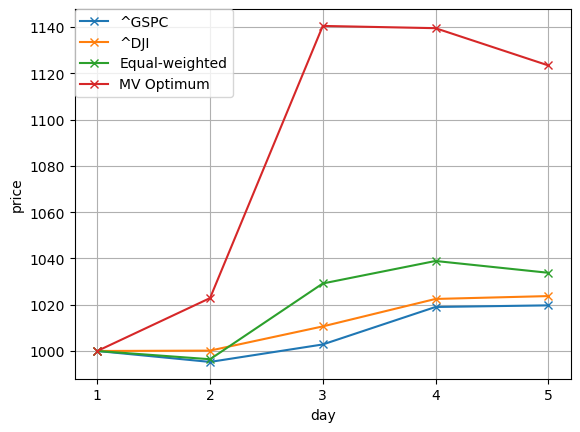

[[0.9648784310007242, 2.122466230234764, 0.801860321819622, 1.222419162972279, 4.929751084654686], [9.594205927110617e-13, -3.244188676005634e-12, -8.991462297356569e-14, 6.112095814859341, 1.1466877160290101e-11]] [0.25187965809796176, 0.030621588339394854]


In [826]:
stock_num=5
stocks_tweet_1 = select_stocks(dates, tweets_df, 2, tweet_acc, stock_num, 7)
w_1 = optimum_portfolio(stocks_tweet_1)
op_weight = w_1['x']
weight_arr = []

# weight_arr.append(ng_weight)
weight_arr.append([1/stock_num for i in range (stock_num)])
weight_arr.append(op_weight)
benckmarks = ['^GSPC', '^DJI']
plot_price(stocks_sa_1, benckmarks, weight_arr)


In [829]:
stocks_sa_1 = select_stocks(dates, sa_df, 2, sa_acc, stock_num,7) 
stocks_sa_1

['BAC', 'ENB', 'IAUX', 'MMM', 'FMX']

In [413]:
sa_top_df_date 

author        date  ticker  \
66         Gen Alpha  2023-02-27     MMM   
67         Gen Alpha  2023-02-27     ENB   
68         Gen Alpha  2023-02-27  ENB.TO   
69         Gen Alpha  2023-02-26    VICI   
130      Taylor Dart  2023-02-27  IAU.TO   
131      Taylor Dart  2023-02-27    IAUX   
171  Stephen Simpson  2023-02-27     FMX   
172  Stephen Simpson  2023-02-27     BAC   
173  Stephen Simpson  2023-02-26      CW   
174  Stephen Simpson  2023-02-26     BRC   

                                               summary  pred_sen  
66   3M is now trading at a very low valuation and ...         2  
67   Enbridge's utilization levels remain high, wit...         2  
68   Enbridge's utilization levels remain high, wit...         2  
69   VICI Properties has achieved impressive growth...         2  
130  i-80 Gold has been one of the best-performing ...         2  
131  i-80 Gold has been one of the best-performing ...         2  
171  FEMSA's fourth quarter results were mixed, wit...         2  
172  Bank of America has lagged since earnings, wit...         2  
173  Curtiss-Wright announced modestly better fourt...         2  
174  Brady produced fiscal second quarter results t...         2